Output: airport_cities.csv, flight_times_extended.csv
To create: dataset with cities, that are not matched between airport_cities and train_cities

# Comparing train and plane travel times

Import of libraries/flight data

In [15]:
# # TODO: delete this cell
# import os
# # set working directory
# os.chdir('/Users/emilejohnston/DataspellProjects/DOPP_group18')
# # show current working directory
# os.getcwd()

## Flight data

### Airlabs API for flight data
this API provides the duration of recent flights all over the world.

In [2]:
# set up
import requests
import pandas as pd
import random

airlab_api_params = {
    "api_key" : "8ffb5e97-7a50-4773-b2d9-8638ec08bc75",
}

airlab_ex_param = {
    "api_key" : "8ffb5e97-7a50-4773-b2d9-8638ec08bc75",
    "dep_iata" : "ANR"
}

checking the types of airports in this database

### Airport info

In [6]:
EURO_IATA_CODES = pd.read_csv('../datasets/fixed-airports-codes.csv')
EURO_IATA_CODES['type'].unique()

array(['heliport', 'small_airport', 'closed', 'seaplane_base',
       'balloonport', 'medium_airport', 'large_airport'], dtype=object)

In [9]:
EU_LARGE = EURO_IATA_CODES.loc[(EURO_IATA_CODES["type"].isin(['large_airport','medium_airport']))  &  (EURO_IATA_CODES['continent'].isin(["EU"]) )][["name","iata_code","iso_region","iso_country","coordinates"]]

# exclude islands and unaccessible airports

airports_to_exclude= ["HER", "NaN","PMI", "LPA", "TFS", "TFN"]
# island countries: Iceland, Ireland
countries_to_exclude = ["IS","IE"]

# data about airports we want to consider:
FINAL_AIRPORTS = EU_LARGE.loc[(~EU_LARGE['iso_country'].isin(countries_to_exclude))  
                              & (~EU_LARGE['iata_code'].isin(airports_to_exclude))
                              & (~EU_LARGE['iata_code'].isna())].reset_index(drop=True)
FINAL_AIRPORTS

,name,iata_code,iso_region,iso_country,coordinates
0,Bezmer Air Base,JAM,BG-28,BG,"26.3521995544, 42.4548988342"
1,PriÅ¡tina International Airport,PRN,XK-01,XK,"21.035801, 42.5728"
2,Antwerp International Airport (Deurne),ANR,BE-VAN,BE,"4.46027994156, 51.1893997192"
3,Brussels Airport,BRU,BE-BRU,BE,"4.48443984985, 50.901401519800004"
4,Brussels South Charleroi Airport,CRL,BE-WHT,BE,"4.45382, 50.459202"
...,...,...,...,...,...
783,Balakovo Airport,BWO,RU-SAR,RU,"47.7456016541, 51.8582992554"
784,Saratov Central Airport,RTW,RU-SAR,RU,"46.04669952392578, 51.564998626708984"
785,Ufa International Airport,UFA,RU-BA,RU,"55.874401092529, 54.557498931885"
786,Kurumoch International Airport,KUF,RU-SAM,RU,"50.16429901123, 53.504901885986"


Save selected large airports to CSV

In [10]:
FINAL_AIRPORTS.to_csv("./datasets/AIRPORT_SET.csv")

### IATA codes of the airports we want to consider

In [36]:
CODES = list(FINAL_AIRPORTS["iata_code"])
# We take a sample of 50 airports to test the API
sample_CODES = random.sample(CODES, 50)
sample_CODES

['ZIA',
 'EDI',
 'SIR',
 'LBC',
 'TIV',
 'MRS',
 'DGP',
 'ZMG',
 'SKG',
 'SZW',
 'CMF',
 'QLT',
 'CSF',
 'MIK',
 'GOA',
 'MOL',
 'LWR',
 'RYG',
 'BLK',
 'MST',
 'NTE',
 'ZTH',
 'GLZ',
 'LHA',
 'LLA',
 'HVG',
 'AOK',
 'STN',
 'HZB',
 'RRS',
 'BZY',
 'PEV',
 'AOI',
 'EXT',
 'BVG',
 'CQF',
 'SVO',
 'JKG',
 'BJF',
 'EIB',
 'VRK',
 'BAY',
 'EPU',
 'SJJ',
 'NHT',
 'GEV',
 'SEK',
 'BWF',
 'LME',
 'FCO']

is Paris Charles-de-Gaulle in the sample?

In [28]:
"CDG" in sample_CODES

False

### API request functions

In [84]:
def get_flight_duration(codes):
    
    # download
    data = []
    for code in codes:
        queryX = {
            "api_key" : "8ffb5e97-7a50-4773-b2d9-8638ec08bc75",
            "dep_iata" :  f"{code}"
        }

        req_get = requests.get("https://airlabs.co/api/v9/schedules?",params= queryX)        
        DF = parse_response(req_get)
        if len(DF) > 0:
            DF = filter_clean_codes(DF, codes)
            data.append(DF)

    DF["route"] = DF.apply(lambda row: set([row["dep"], row["arr"]]), axis=1)
    DF = DF.loc[["route","time"]]
    DF.drop_duplicates(inplace=True, ignore_index=True)
  
    # concat all and return 
    return pd.concat(data, ignore_index=True)



def parse_response(api_response):
    """
    Keyword arguments:
    api_response -- GET response
    Return: pd.DataFrame of flight routes
    """

    j_resp = api_response.json()
    flight_list = j_resp['response']
    
    flights = []
    for fl in flight_list:
        one_flight = {"dep":fl['dep_iata'],
                      "arr":fl['arr_iata'],
                      "time":fl['duration']}
        flights.append(one_flight)

    print(flight_list)
    return pd.DataFrame(flights)

def filter_clean_codes(flight_set, codes):
    df = flight_set[ (flight_set["dep"].isin(codes)) & (flight_set["arr"].isin(codes))]
    # uDF = df.loc[["route","time"]]
    return df.drop_duplicates(ignore_index=True)

In [85]:
Flights= get_flight_duration(CODES)
Flights.head()

KeyError: 'response'

### Obtaining flight times

In [88]:
Flights.to_csv("./datasets/Flights1.csv") # saving it so that we don't have to re-run API cells

we add a route column to the dataframe so that each route has a unique and meaningful identifier

In [96]:
Flights["route"] = Flights.apply(lambda row: str( set([row["dep"], row["arr"]]) ), axis=1)
Flights

,dep,arr,time,route
0,PRN,STR,125,"{'PRN', 'STR'}"
1,PRN,DUS,160,"{'DUS', 'PRN'}"
2,PRN,DUS,165,"{'DUS', 'PRN'}"
3,PRN,MUC,120,"{'MUC', 'PRN'}"
4,PRN,HAM,165,"{'PRN', 'HAM'}"
...,...,...,...,...
2271,KUF,LED,145,"{'KUF', 'LED'}"
2272,KUF,VKO,120,"{'VKO', 'KUF'}"
2273,KUF,LED,150,"{'KUF', 'LED'}"
2274,KUF,SVO,115,"{'SVO', 'KUF'}"


### Average of return flights
Most flights have a time specified for both directions, but we only interested in a unified time for the connection between the two cities, so we take the average of the times in both directions, which often differ by 5 or 10 minutes

In [107]:
FlightsShort = Flights[["route", "time"]].groupby(["route"]).mean()
FlightsShort.reset_index(inplace=True)
FlightsShort["route"] = FlightsShort["route"].apply(lambda x: eval(x))
FlightsShort["dep"] 

,route,time
0,"{AAL, AMS}",85.0
1,"{AAQ, LED}",170.0
2,"{AMS, ABZ}",85.0
3,"{ABZ, LGW}",95.0
4,"{ACE, AGP}",130.0
...,...,...
1464,"{ZRH, OTP}",150.0
1465,"{ZRH, PRN}",127.5
1466,"{ZRH, RVN}",205.0
1467,"{ZRH, STR}",45.0


In [109]:
FlightsShort.to_csv("./datasets/europe_flights.csv") # saving it so that we don't have to re-run API cells

In [17]:
queryCDG = {
    "api_key" : "8ffb5e97-7a50-4773-b2d9-8638ec08bc75",
    "dep_iata" :  "CDG"   
}


res_ex = requests.get("https://airlabs.co/api/v9/schedules?",params= queryCDG)
js_res = res_ex.json()
js_res["response"]

[{'airline_iata': 'AH',
  'airline_icao': 'DAH',
  'flight_iata': 'AH1149',
  'flight_icao': 'DAH1149',
  'flight_number': '1149',
  'dep_iata': 'CDG',
  'dep_icao': 'LFPG',
  'dep_terminal': '2D',
  'dep_gate': 'B31',
  'dep_time': '2024-01-20 14:00',
  'dep_time_utc': '2024-01-20 13:00',
  'dep_estimated': '2024-01-20 14:34',
  'dep_estimated_utc': '2024-01-20 13:34',
  'dep_actual': '2024-01-20 14:34',
  'dep_actual_utc': '2024-01-20 13:34',
  'arr_iata': 'CFK',
  'arr_icao': 'DAOI',
  'arr_terminal': None,
  'arr_gate': None,
  'arr_baggage': None,
  'arr_time': '2024-01-20 16:35',
  'arr_time_utc': '2024-01-20 15:35',
  'arr_estimated': '2024-01-20 16:43',
  'arr_estimated_utc': '2024-01-20 15:43',
  'cs_airline_iata': None,
  'cs_flight_number': None,
  'cs_flight_iata': None,
  'status': 'active',
  'duration': 155,
  'delayed': 8,
  'dep_delayed': 34,
  'arr_delayed': 8,
  'aircraft_icao': 'B738',
  'arr_time_ts': 1705764900,
  'dep_time_ts': 1705755600,
  'arr_estimated_ts': 1

Get sample of api request for connections between given airports 


In [43]:
DF = parse_response(res_ex)
DF.head()

,dep,arr,time
0,CDG,CFK,155
1,CDG,ALG,135
2,CDG,FRA,80
3,CDG,ATL,590
4,CDG,ATL,590


In [53]:
filter_clean_codes(DF, CODES)

,dep,arr,time
0,CDG,FRA,80
1,CDG,AMS,80
2,CDG,OSL,140
3,CDG,GOT,125
4,CDG,CPH,115
5,CDG,TLS,80
6,CDG,ZRH,75
7,CDG,PRG,105
8,CDG,ARN,160


### Processing of flight data

In [16]:
import pandas as pd

In [17]:
flights = pd.read_csv('../datasets/flight_times.csv')
flights

,Unnamed: 0,route,time
0,0,"{'AAL', 'AMS'}",85.0
1,1,"{'AAQ', 'LED'}",170.0
2,2,"{'AMS', 'ABZ'}",85.0
3,3,"{'ABZ', 'LGW'}",95.0
4,4,"{'ACE', 'AGP'}",130.0
...,...,...,...
1464,1464,"{'ZRH', 'OTP'}",150.0
1465,1465,"{'ZRH', 'PRN'}",127.5
1466,1466,"{'ZRH', 'RVN'}",205.0
1467,1467,"{'ZRH', 'STR'}",45.0


In [18]:
flights.drop(flights.columns[0], axis=1, inplace=True)
flights

,route,time
0,"{'AAL', 'AMS'}",85.0
1,"{'AAQ', 'LED'}",170.0
2,"{'AMS', 'ABZ'}",85.0
3,"{'ABZ', 'LGW'}",95.0
4,"{'ACE', 'AGP'}",130.0
...,...,...
1464,"{'ZRH', 'OTP'}",150.0
1465,"{'ZRH', 'PRN'}",127.5
1466,"{'ZRH', 'RVN'}",205.0
1467,"{'ZRH', 'STR'}",45.0


In [19]:
flights['departure airport'] = flights['route'].apply(lambda x: x.split(',')[0].strip("{'"))
flights['arrival airport'] = flights['route'].apply(lambda x: x.split(',')[1].strip(" }'"))
flights

,route,time,departure airport,arrival airport
0,"{'AAL', 'AMS'}",85.0,AAL,AMS
1,"{'AAQ', 'LED'}",170.0,AAQ,LED
2,"{'AMS', 'ABZ'}",85.0,AMS,ABZ
3,"{'ABZ', 'LGW'}",95.0,ABZ,LGW
4,"{'ACE', 'AGP'}",130.0,ACE,AGP
...,...,...,...,...
1464,"{'ZRH', 'OTP'}",150.0,ZRH,OTP
1465,"{'ZRH', 'PRN'}",127.5,ZRH,PRN
1466,"{'ZRH', 'RVN'}",205.0,ZRH,RVN
1467,"{'ZRH', 'STR'}",45.0,ZRH,STR


### Using municipality names from the airport codes dataset

In [20]:
# new dataset, which is the same but without the encoding error:
airports = pd.read_csv('../datasets/fixed-airports-codes.csv')
airports

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11.0,NaN,US,US-PA,Bensalem,no,K00A,NaN,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,00AN,NaN,00AN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78148,46378,ZZ-0001,heliport,Sealand Helipad,51.894444,1.482500,40.0,EU,GB,GB-ENG,Sealand,no,NaN,NaN,NaN,http://www.sealandgov.org/,https://en.wikipedia.org/wiki/Principality_of_...,Roughs Tower Helipad
78149,307326,ZZ-0002,small_airport,Glorioso Islands Airstrip,-11.584278,47.296389,11.0,AF,TF,TF-U-A,Grande Glorieuse,no,NaN,NaN,NaN,NaN,NaN,NaN
78150,346788,ZZ-0003,small_airport,Fainting Goat Airport,32.110587,-97.356312,690.0,NaN,US,US-TX,Blum,no,87TX,NaN,87TX,NaN,NaN,NaN
78151,342102,ZZZW,closed,Scandium City Heliport,69.355287,-138.939310,4.0,NaN,CA,CA-YT,(Old) Scandium City,no,NaN,NaN,NaN,NaN,NaN,"ZZZW, ZZZW, ZYW, YK96"


In [22]:
cities = airports[['iata_code', 'municipality']]
cities

,iata_code,municipality
0,NaN,Bensalem
1,NaN,Leoti
2,NaN,Anchor Point
3,NaN,Harvest
4,NaN,King Salmon
...,...,...
78148,NaN,Sealand
78149,NaN,Grande Glorieuse
78150,NaN,Blum
78151,NaN,(Old) Scandium City


### Merging flights with municipality names

In [23]:
# add departure city names
flights = pd.merge(flights, cities, left_on='departure airport', right_on='iata_code', how='left')
# remove the redundant column
flights.drop('iata_code', axis=1, inplace=True)
# rename the column
flights.rename(columns={'municipality': 'departure city'}, inplace=True)
# add arrival city names
flights = pd.merge(flights, cities, left_on='arrival airport', right_on='iata_code', how='left')
# remove the redundant column
flights.drop('iata_code', axis=1, inplace=True)
# rename the column
flights.rename(columns={'municipality': 'arrival city'}, inplace=True)
flights

,route,time,departure airport,arrival airport,departure city,arrival city
0,"{'AAL', 'AMS'}",85.0,AAL,AMS,Aalborg,Amsterdam
1,"{'AAQ', 'LED'}",170.0,AAQ,LED,Krasnyi Kurgan,St. Petersburg
2,"{'AMS', 'ABZ'}",85.0,AMS,ABZ,Amsterdam,Aberdeen
3,"{'ABZ', 'LGW'}",95.0,ABZ,LGW,Aberdeen,"Gatwick, Surrey"
4,"{'ACE', 'AGP'}",130.0,ACE,AGP,San Bartolomé,Málaga
...,...,...,...,...,...,...
1464,"{'ZRH', 'OTP'}",150.0,ZRH,OTP,Zurich,Otopeni
1465,"{'ZRH', 'PRN'}",127.5,ZRH,PRN,Zurich,Prishtina
1466,"{'ZRH', 'RVN'}",205.0,ZRH,RVN,Zurich,Rovaniemi
1467,"{'ZRH', 'STR'}",45.0,ZRH,STR,Zurich,Stuttgart


Does the 'municipality' variable refer to the actual administrative division that the airport is located in, or the big city it's next to? Let's check.

In [24]:
flights[flights['departure city'].str.contains('London')]

,route,time,departure airport,arrival airport,departure city,arrival city
698,"{'LHR', 'ABZ'}",95.0,LHR,ABZ,London,Aberdeen
699,"{'LHR', 'AGP'}",185.0,LHR,AGP,London,Málaga
700,"{'LHR', 'AMS'}",85.0,LHR,AMS,London,Amsterdam
701,"{'LHR', 'ARN'}",160.0,LHR,ARN,London,Stockholm
702,"{'LHR', 'ATH'}",245.0,LHR,ATH,London,Spata-Artemida
...,...,...,...,...,...,...
1201,"{'STN', 'VRN'}",122.5,STN,VRN,London,Caselle (VR)
1202,"{'STN', 'WMI'}",135.0,STN,WMI,London,Warsaw
1203,"{'STN', 'WRO'}",125.0,STN,WRO,London,Wrocław
1204,"{'STN', 'ZAG'}",135.0,STN,ZAG,London,Zagreb


In [25]:
flights.to_csv("../datasets/flight_times_extended.csv") # saving it to avoid re-running cells

### Extracting a set of airport cities

In [26]:
airport_cites = set(flights["departure city"]) | set(flights["arrival city"])
airport_cites = pd.DataFrame(airport_cites)
airport_cites.to_csv("../datasets/airport_cities.csv",index=False, header=False)
airport_cites[0]

0              Almería
1           Düsseldorf
2               Greven
3            Newcastle
4             Salzburg
            ...       
299    Nizhny Novgorod
300         Kos Island
301              Paris
302             Geneva
303          Nuremberg
Name: 0, Length: 304, dtype: object

## Train data: Rail transport performance in Europe in 2021

### Importing and exploring the data

Output: train_routes.csv, train_cities.csv

In [128]:
import pandas as pd

In [129]:
df = pd.read_csv('datasets/Rail_transport_performance_in_Europe_2021.csv')

In [130]:
df

,country_larger_city,HDC_code_larger,larger_city,pop_larger_city,country_smaller_city,HDC_code_smaller,smaller_city,pop_smaller_city,crossborder,distance_centroids,av_dist_opti,time_opti,speed_opti,av_dist_avt,time_avt,speed_avt
0,FR,GEOSTAT11_450,Paris,8900172,BE,GEOSTAT11_349,Bruxelles / Brussel,1233487,True,more than 120 km,260.8,1.44,182.1,261.6,1.71,153.5
1,FR,GEOSTAT11_450,Paris,8900172,FR,GEOSTAT11_361,Lille,911478,False,more than 120 km,202.0,1.00,202.1,201.9,1.29,157.3
2,FR,GEOSTAT11_450,Paris,8900172,FR,GEOSTAT11_418,Rouen,298297,False,114.6,110.0,1.24,88.7,110.0,1.67,65.9
3,FR,GEOSTAT11_450,Paris,8900172,FR,GEOSTAT11_434,Cergy-Pontoise,273138,False,30.6,4.8,0.07,67.9,4.8,0.17,27.9
4,FR,GEOSTAT11_450,Paris,8900172,FR,GEOSTAT11_499,Tours,211915,False,more than 120 km,187.7,0.86,218.2,200.4,1.54,130.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6594,HU,GEOSTAT11_506,Szolnok,51457,HU,GEOSTAT11_500,Érd,51285,False,99.6,NaN,NaN,NaN,NaN,NaN,NaN
6595,HU,GEOSTAT11_500,Érd,51285,HU,GEOSTAT11_516,Veszprém,50141,False,82.2,NaN,NaN,NaN,NaN,NaN,NaN
6596,IT,GEOSTAT11_770,Bitonto,50961,IT,GEOSTAT11_734,Manfredonia,50684,False,86.8,NaN,NaN,NaN,NaN,NaN,NaN
6597,IT,GEOSTAT11_770,Bitonto,50961,IT,GEOSTAT11_761,Cerignola,50074,False,68.5,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
df['country_larger_city'].value_counts()

UK    2336
NL    1037
DE    1025
ES     496
IT     487
PL     301
FR     287
BE     184
RO      91
CZ      75
CH      68
HU      43
BG      42
SE      30
SK      24
PT      20
AT      16
DK       7
SI       7
LT       5
IE       4
EL       4
FI       3
HR       3
LU       3
NO       1
Name: country_larger_city, dtype: int64

<Axes: >

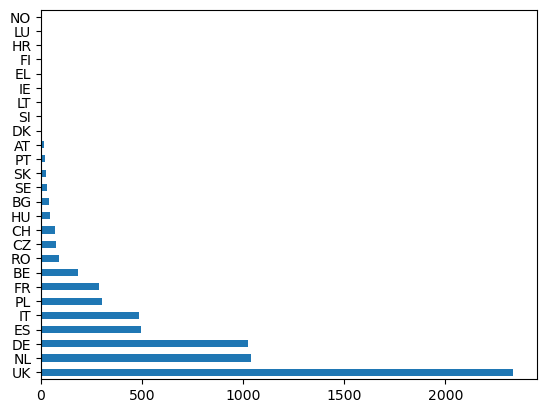

In [132]:
df['country_larger_city'].value_counts().plot(kind='barh')

In [133]:
df['country_smaller_city'].value_counts()

UK    2335
NL    1066
DE     982
ES     490
IT     481
FR     280
PL     271
BE     204
CZ     104
RO      92
CH      63
HU      55
BG      36
SK      31
SE      30
PT      22
AT      17
DK       7
EL       5
MC       5
IE       4
SI       4
HR       4
FI       3
LT       3
LU       3
NO       1
LV       1
Name: country_smaller_city, dtype: int64

In [134]:
df['time_opti'].describe()

count    3434.000000
mean        0.948771
std         0.399241
min         0.030000
25%         0.660000
50%         1.020000
75%         1.290000
max         1.500000
Name: time_opti, dtype: float64

In [135]:
df['time_avt'].describe()

count    3434.000000
mean        1.563730
std         1.265469
min         0.100000
25%         1.050000
50%         1.500000
75%         1.840000
max        17.600000
Name: time_avt, dtype: float64

### Data processing

In [139]:
tmpDF = df[["larger_city","smaller_city","time_avt","time_opti"]].copy()
tmpDF.head()

,larger_city,smaller_city,time_avt,time_opti
0,Paris,Bruxelles / Brussel,1.71,1.44
1,Paris,Lille,1.29,1.00
2,Paris,Rouen,1.67,1.24
3,Paris,Cergy-Pontoise,0.17,0.07
4,Paris,Tours,1.54,0.86


Cleaning

In [140]:
tmpDF.dropna(inplace=True)

tmpDF["time_opti[min]"] = tmpDF["time_opti"] * 60
tmpDF["time_avg[min]"] = tmpDF["time_avt"]* 60

routes = tmpDF.rename(columns={"larger_city":"city_1",
                       "smaller_city":"city_2",
                       "time_opti":"time_opti[h]",
                       "time_avt":"time_avg[h]"})

routes

,city_1,city_2,time_avg[h],time_opti[h],time_opti[min],time_avg[min]
0,Paris,Bruxelles / Brussel,1.71,1.44,86.4,102.6
1,Paris,Lille,1.29,1.00,60.0,77.4
2,Paris,Rouen,1.67,1.24,74.4,100.2
3,Paris,Cergy-Pontoise,0.17,0.07,4.2,10.2
4,Paris,Tours,1.54,0.86,51.6,92.4
...,...,...,...,...,...,...
6575,Trani,Manfredonia,3.88,1.13,67.8,232.8
6582,Kettering,Corby,0.83,0.14,8.4,49.8
6584,San Severo,Bisceglie,2.69,1.10,66.0,161.4
6585,San Severo,Manfredonia,4.26,0.85,51.0,255.6


Issue: Double names

In [141]:
names1 = routes.loc[ routes["city_1"].str.contains("/")]["city_1"].unique()
names2 = routes.loc[ routes["city_2"].str.contains("/")]["city_2"].unique()

double_names = set(names2).union(set(names1))
pd.DataFrame(double_names).to_csv("./datasets/double_names_list.csv")
double_names

{'Aldwick / Felpham',
 'Alicante/Alacant',
 'Anzio / Nettuno',
 'Arcozelo / Espinho',
 'Ayr / Prestwick',
 'Bad Soden am Taunus / Kelkheim',
 'Beverwijk/Heemskerk',
 'Biel/Bienne',
 'Blantyre / Hamilton',
 'Bruxelles / Brussel',
 'Cannock / Hednesford',
 'Castellón de la Plana/Castelló de la Plana',
 'Chomutov / Jirkov',
 'Elche/Elx',
 'Frimley / Farnborough',
 'Gevelsberg / Schwelm',
 'Greve / Ishøj',
 'Grimsby / Cleethorpes',
 'Gröpelingen / Vegesack',
 'Kapellen / Ekeren',
 'Leeds / Bradford',
 'Lørenskog / Lillestrøm',
 'Mannheim/Ludwigshafen',
 'Martigues / Port-de-Bouc',
 'Maurepas / Montigny-le-Bretonneux',
 'Moers / Rheinhausen',
 'Motherwell / Wishaw',
 'Pamplona/Iruña',
 'Pozzuoli / Bacoli',
 'Quaregnon / Frameries',
 'Redhill / Reigate',
 'San Sebastián/Donostia',
 'Sant Cugat del Vallès/Rubí',
 'Soest / Baarn',
 'Solingen / Wuppertal',
 'Swords / Malahide',
 'Tampere / Tammerfors',
 'Ulm/Neu-Ulm',
 'Vaihingen / Möhringen',
 'Verviers / Dison',
 'Vitoria/Gasteiz',
 'Vleuten 

So far "double names" issue is an issue for limmited amount of cities. Most of them are small cities which have no direct access to airport. Therefore only "left" name will be taken as it represent the bigger one of cities or its international name

In [142]:
routes["city_1"] = routes["city_1"].apply(lambda x: x.split(" /")[0].strip())
routes["city_2"] = routes["city_2"].apply(lambda x: x.split(" /")[0].strip())
routes

,city_1,city_2,time_avg[h],time_opti[h],time_opti[min],time_avg[min]
0,Paris,Bruxelles,1.71,1.44,86.4,102.6
1,Paris,Lille,1.29,1.00,60.0,77.4
2,Paris,Rouen,1.67,1.24,74.4,100.2
3,Paris,Cergy-Pontoise,0.17,0.07,4.2,10.2
4,Paris,Tours,1.54,0.86,51.6,92.4
...,...,...,...,...,...,...
6575,Trani,Manfredonia,3.88,1.13,67.8,232.8
6582,Kettering,Corby,0.83,0.14,8.4,49.8
6584,San Severo,Bisceglie,2.69,1.10,66.0,161.4
6585,San Severo,Manfredonia,4.26,0.85,51.0,255.6


Save:
- train_cities.csv
- train_routes.csv

In [126]:
cities_set = set(routes["city_1"].unique()).union(routes["city_2"].unique())
train_cities = pd.DataFrame(cities_set)
train_cities.to_csv("./datasets/train_cities.csv",index=False, header=False)

In [144]:
routes.reset_index(inplace=True)
routes.to_csv("./datasets/train_routes.csv", index=False)

### SNCF API attempt

Trying to download the SNCF source schedules for train connections

In [136]:
import requests

api_key1 = "0dca33cf-7a3b-4c16-9baf-534bbdaf98b6"
api_key2 = "e86651c5-6924-48f0-b872-95ea08560ffe"

sncf_params = {
    "token": "e86651c5-6924-48f0-b872-95ea08560ffe"
}

In [137]:
sncf_req = requests.get(f"https://{api_key2}@api.sncf.com/v1/")
sncf_req.json()

{'links': [{'href': 'https://api.sncf.com/v1/coverage/',
   'templated': False,
   'rel': 'coverage',
   'type': 'coverage',
   'title': 'Coverage of navitia'},
  {'href': 'https://api.sncf.com/v1/coord/0.0%3B0.0/',
   'templated': True,
   'rel': 'coord',
   'type': 'coord',
   'title': 'Inverted geocoding for a given coordinate'},
  {'href': 'https://api.sncf.com/v1/journeys',
   'templated': False,
   'rel': 'journeys',
   'type': 'journeys',
   'title': 'Compute journeys'},
  {'href': 'https://api.sncf.com/v1/places',
   'templated': False,
   'rel': 'places',
   'type': 'places',
   'title': 'Autocomplete api'}]}

The API doesn't work, we have to try something else

In [138]:
req_get = requests.get("https://apis.deutschebahn.com/db-api-marketplace/apis/timetables/v1/plan/")
req_get.json()

{'httpCode': '404',
 'httpMessage': 'Not Found',
 'moreInformation': 'No resources match requested URI'}

The Deutsche Bahn API doesn't work either, because we didn't get the API keys we requested

## Intersection of cities from flight and train data 

Now we need to check that the train and plane datasets are using the same city names. We'll do this by checking that the city names in the plane dataset are a subset of the city names in the train dataset.

Import of train routes preprocessed in "Rail transport performance.ipnyb"

In [27]:
trains  = pd.read_csv('../datasets/train_routes.csv')
train_cities = pd.read_csv("../datasets/train_cities.csv")
trains = trains.iloc[:,1:]
train_cities

,city
0,St. Gallen
1,Cremona
2,Gütersloh
3,Basel
4,Salzburg
...,...
656,Bruxelles
657,Parla
658,Iserlohn
659,Harrogate


In [28]:
airport_cities_set = set(airport_cites[0])
airport_cities_set

{'Aalborg',
 'Aarhus',
 'Aberdeen',
 'Ajaccio/Napoléon Bonaparte',
 'Alexandroupolis',
 'Alghero',
 'Alicante',
 'Almería',
 'Amsterdam',
 'Ancona',
 'Andenes',
 'Archangelsk',
 'Astrakhan',
 'Bacău',
 'Balice',
 'Banja Luka',
 'Barcelona',
 'Bari',
 'Bastia/Poretta',
 'Belfast',
 'Belgrade',
 'Bergen',
 'Beslan',
 'Bilbao',
 'Billund',
 'Birmingham',
 'Bodø',
 'Bologna',
 'Bolzano (BZ)',
 'Bordeaux/Mérignac',
 'Bournemouth',
 'Bragança',
 'Bratislava',
 'Bremen',
 'Brindisi',
 'Bristol',
 'Brønnøy',
 'Budapest',
 'Bugulma',
 'Burgas',
 'Bydgoszcz',
 'Béziers/Vias',
 'Cagliari',
 'Calvi/Sainte-Catherine',
 'Cardiff',
 'Cascais',
 'Caselle (VR)',
 'Caselle Torinese (TO)',
 'Castellón de la Plana',
 'Castletown',
 'Catania',
 'Charleroi',
 'Cheboksary',
 'Chelyabinsk',
 'Cherepovets',
 'Chios Island',
 'Chita',
 'Chişinău',
 'Cluj-Napoca',
 'Copenhagen',
 'Corvera',
 'Craiova',
 'Crete Island',
 'Crotone',
 'Culleredo',
 'Debrecen',
 'Dortmund',
 'Dresden',
 'Dubrave Gornje',
 'Düsseldor

In [29]:
train_cities_set = set(train_cities["city"])
train_cities_set

{"'s-Hertogenbosch",
 'A Coruña',
 'Aachen',
 'Aberdeen',
 'Acerra',
 'Acireale',
 'Aix-en-Provence',
 'Albacete',
 'Alcalá de Henares',
 'Aldwick',
 'Alessandria',
 'Alicante/Alacant',
 'Alkmaar',
 'Almada',
 'Almelo',
 'Almere',
 'Alphen aan den Rijn',
 'Amersfoort',
 'Amiens',
 'Amsterdam',
 'Ancona',
 'Angers',
 'Annecy',
 'Antibes',
 'Antwerpen',
 'Anzio',
 'Apeldoorn',
 'Arad',
 'Arcozelo',
 'Arezzo',
 'Arnhem',
 'Arras',
 'Ashford',
 'Assen',
 'Asti',
 'Augsburg',
 'Avellino',
 'Avignon',
 'Aylesbury',
 'Ayr',
 'Bacău',
 'Bad Soden am Taunus',
 'Badajoz',
 'Bagheria',
 'Baia Mare',
 'Bamberg',
 'Bangor',
 'Banská Bystrica',
 'Barcelona',
 'Bari',
 'Barletta',
 'Barnsley',
 'Barreiro',
 'Basel',
 'Basildon',
 'Basingstoke and Deane',
 'Bath',
 'Battipaglia',
 'Bayonne',
 'Bayreuth',
 'Bedford',
 'Belfast',
 'Belfort',
 'Benrath',
 'Bergamo',
 'Bergen op Zoom',
 'Berlin',
 'Bern',
 'Besançon',
 'Beverwijk/Heemskerk',
 'Białystok',
 'Biel/Bienne',
 'Bielefeld',
 'Bielsko-Biała',
 '

Which cities are in the airport dataset but not the train dataset?

In [30]:
len(airport_cities_set - train_cities_set)

232

Names we have in both

In [31]:
airport_cities_set & train_cities_set

{'Aberdeen',
 'Amsterdam',
 'Ancona',
 'Bacău',
 'Barcelona',
 'Bari',
 'Belfast',
 'Birmingham',
 'Bologna',
 'Bournemouth',
 'Bratislava',
 'Bremen',
 'Brindisi',
 'Bristol',
 'Budapest',
 'Bydgoszcz',
 'Cardiff',
 'Catania',
 'Charleroi',
 'Dresden',
 'Düsseldorf',
 'Edinburgh',
 'Eindhoven',
 'Firenze',
 'Frankfurt am Main',
 'Gdańsk',
 'Girona',
 'Hamburg',
 'Hannover',
 'Helsinki',
 'Innsbruck',
 'Jerez de la Frontera',
 'Leeds',
 'Liverpool',
 'London',
 'Lublin',
 'Luxembourg',
 'Lyon',
 'Maastricht',
 'Madrid',
 'Malmö',
 'Marseille',
 'Málaga',
 'Nantes',
 'Napoli',
 'Nice',
 'Olsztyn',
 'Oslo',
 'Palermo',
 'Paris',
 'Perugia',
 'Pescara',
 'Pisa',
 'Porto',
 'Poznań',
 'Radom',
 'Rotterdam',
 'Salzburg',
 'Santander',
 'Santiago de Compostela',
 'Sevilla',
 'Southampton',
 'Stockholm',
 'Stuttgart',
 'Thessaloniki',
 'Timişoara',
 'Valencia',
 'Varna',
 'Vigo',
 'Wrocław',
 'Zaragoza',
 'Łódź'}

Names in Airports, not in train_stations

In [32]:
train_cities_set - airport_cities_set

{"'s-Hertogenbosch",
 'A Coruña',
 'Aachen',
 'Acerra',
 'Acireale',
 'Aix-en-Provence',
 'Albacete',
 'Alcalá de Henares',
 'Aldwick',
 'Alessandria',
 'Alicante/Alacant',
 'Alkmaar',
 'Almada',
 'Almelo',
 'Almere',
 'Alphen aan den Rijn',
 'Amersfoort',
 'Amiens',
 'Angers',
 'Annecy',
 'Antibes',
 'Antwerpen',
 'Anzio',
 'Apeldoorn',
 'Arad',
 'Arcozelo',
 'Arezzo',
 'Arnhem',
 'Arras',
 'Ashford',
 'Assen',
 'Asti',
 'Augsburg',
 'Avellino',
 'Avignon',
 'Aylesbury',
 'Ayr',
 'Bad Soden am Taunus',
 'Badajoz',
 'Bagheria',
 'Baia Mare',
 'Bamberg',
 'Bangor',
 'Banská Bystrica',
 'Barletta',
 'Barnsley',
 'Barreiro',
 'Basel',
 'Basildon',
 'Basingstoke and Deane',
 'Bath',
 'Battipaglia',
 'Bayonne',
 'Bayreuth',
 'Bedford',
 'Belfort',
 'Benrath',
 'Bergamo',
 'Bergen op Zoom',
 'Berlin',
 'Bern',
 'Besançon',
 'Beverwijk/Heemskerk',
 'Białystok',
 'Biel/Bienne',
 'Bielefeld',
 'Bielsko-Biała',
 'Bisceglie',
 'Blackburn with Darwen',
 'Blackpool',
 'Blanchardstown',
 'Blantyre',

In [33]:
airport_cities_set - train_cities_set

{'Aalborg',
 'Aarhus',
 'Ajaccio/Napoléon Bonaparte',
 'Alexandroupolis',
 'Alghero',
 'Alicante',
 'Almería',
 'Andenes',
 'Archangelsk',
 'Astrakhan',
 'Balice',
 'Banja Luka',
 'Bastia/Poretta',
 'Belgrade',
 'Bergen',
 'Beslan',
 'Bilbao',
 'Billund',
 'Bodø',
 'Bolzano (BZ)',
 'Bordeaux/Mérignac',
 'Bragança',
 'Brønnøy',
 'Bugulma',
 'Burgas',
 'Béziers/Vias',
 'Cagliari',
 'Calvi/Sainte-Catherine',
 'Cascais',
 'Caselle (VR)',
 'Caselle Torinese (TO)',
 'Castellón de la Plana',
 'Castletown',
 'Cheboksary',
 'Chelyabinsk',
 'Cherepovets',
 'Chios Island',
 'Chita',
 'Chişinău',
 'Cluj-Napoca',
 'Copenhagen',
 'Corvera',
 'Craiova',
 'Crete Island',
 'Crotone',
 'Culleredo',
 'Debrecen',
 'Dortmund',
 'Dubrave Gornje',
 'El Matorral',
 'Evenes',
 'Faro',
 'Feldkirchen bei Graz',
 'Ferno (VA)',
 'Figari Sud-Corse',
 'Florø',
 'Frankfurt am Main (Lautzenhausen)',
 'Funchal',
 'Gatwick, Surrey',
 'Gelendzhik',
 'Geneva',
 'Genova (GE)',
 'Gibraltar',
 'Goleniow',
 'Gothenburg',
 'Gr

## Pipeline for matching routes
input: a list of cities
output: a dataset with routes, train travel times and plane travel times

### Intersecting cities

In [34]:
intersecting_cities = airport_cities_set & train_cities_set # TODO: change this variable to integrate more cities
print(f'Number of cities we are working with: {len(intersecting_cities)}')
intersecting_cities

Number of cities we are working with: 72


{'Aberdeen',
 'Amsterdam',
 'Ancona',
 'Bacău',
 'Barcelona',
 'Bari',
 'Belfast',
 'Birmingham',
 'Bologna',
 'Bournemouth',
 'Bratislava',
 'Bremen',
 'Brindisi',
 'Bristol',
 'Budapest',
 'Bydgoszcz',
 'Cardiff',
 'Catania',
 'Charleroi',
 'Dresden',
 'Düsseldorf',
 'Edinburgh',
 'Eindhoven',
 'Firenze',
 'Frankfurt am Main',
 'Gdańsk',
 'Girona',
 'Hamburg',
 'Hannover',
 'Helsinki',
 'Innsbruck',
 'Jerez de la Frontera',
 'Leeds',
 'Liverpool',
 'London',
 'Lublin',
 'Luxembourg',
 'Lyon',
 'Maastricht',
 'Madrid',
 'Malmö',
 'Marseille',
 'Málaga',
 'Nantes',
 'Napoli',
 'Nice',
 'Olsztyn',
 'Oslo',
 'Palermo',
 'Paris',
 'Perugia',
 'Pescara',
 'Pisa',
 'Porto',
 'Poznań',
 'Radom',
 'Rotterdam',
 'Salzburg',
 'Santander',
 'Santiago de Compostela',
 'Sevilla',
 'Southampton',
 'Stockholm',
 'Stuttgart',
 'Thessaloniki',
 'Timişoara',
 'Valencia',
 'Varna',
 'Vigo',
 'Wrocław',
 'Zaragoza',
 'Łódź'}

### Train routes

In [35]:
train_routes = pd.read_csv('../datasets/train_routes.csv') # TODO: change how the dataframe is obtained, it should be directly in the notebook and not from a csv file
train_routes

,index,city_1,city_2,time_avg[h],time_opti[h],time_opti[min],time_avg[min]
0,0,Paris,Bruxelles,1.71,1.44,86.4,102.6
1,1,Paris,Lille,1.29,1.00,60.0,77.4
2,2,Paris,Rouen,1.67,1.24,74.4,100.2
3,3,Paris,Cergy-Pontoise,0.17,0.07,4.2,10.2
4,4,Paris,Tours,1.54,0.86,51.6,92.4
...,...,...,...,...,...,...,...
3429,6575,Trani,Manfredonia,3.88,1.13,67.8,232.8
3430,6582,Kettering,Corby,0.83,0.14,8.4,49.8
3431,6584,San Severo,Bisceglie,2.69,1.10,66.0,161.4
3432,6585,San Severo,Manfredonia,4.26,0.85,51.0,255.6


In [36]:
reduced_train_routes = train_routes[(train_routes['city_1'].isin(intersecting_cities)) & (train_routes['city_2'].isin(intersecting_cities))]
reduced_train_routes

,index,city_1,city_2,time_avg[h],time_opti[h],time_opti[min],time_avg[min]
22,22,London,Birmingham,1.52,1.11,66.6,91.2
25,25,London,Bristol,1.82,1.48,88.8,109.2
29,29,London,Southampton,1.45,1.14,68.4,87.0
87,87,Madrid,Zaragoza,1.99,1.43,85.8,119.4
169,187,Barcelona,Zaragoza,2.05,1.47,88.2,123.0
175,194,Barcelona,Girona,1.21,0.63,37.8,72.6
186,208,Birmingham,Liverpool,1.44,1.10,66.0,86.4
188,210,Birmingham,Bristol,1.66,1.38,82.8,99.6
287,340,Hamburg,Hannover,1.57,1.27,76.2,94.2
288,341,Hamburg,Bremen,1.22,0.91,54.6,73.2


In [37]:
reduced_train_routes['trip'] = reduced_train_routes.apply(lambda row: {row['city_1'], row['city_2']}, axis=1)
reduced_train_routes

/var/folders/x2/jj0kgq010j128mdwvs89btf00000gp/T/ipykernel_40187/1158335715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_train_routes['trip'] = reduced_train_routes.apply(lambda row: {row['city_1'], row['city_2']}, axis=1)


,index,city_1,city_2,time_avg[h],time_opti[h],time_opti[min],time_avg[min],trip
22,22,London,Birmingham,1.52,1.11,66.6,91.2,"{Birmingham, London}"
25,25,London,Bristol,1.82,1.48,88.8,109.2,"{Bristol, London}"
29,29,London,Southampton,1.45,1.14,68.4,87.0,"{Southampton, London}"
87,87,Madrid,Zaragoza,1.99,1.43,85.8,119.4,"{Zaragoza, Madrid}"
169,187,Barcelona,Zaragoza,2.05,1.47,88.2,123.0,"{Zaragoza, Barcelona}"
175,194,Barcelona,Girona,1.21,0.63,37.8,72.6,"{Girona, Barcelona}"
186,208,Birmingham,Liverpool,1.44,1.10,66.0,86.4,"{Liverpool, Birmingham}"
188,210,Birmingham,Bristol,1.66,1.38,82.8,99.6,"{Bristol, Birmingham}"
287,340,Hamburg,Hannover,1.57,1.27,76.2,94.2,"{Hannover, Hamburg}"
288,341,Hamburg,Bremen,1.22,0.91,54.6,73.2,"{Bremen, Hamburg}"


To be able to perform an inner join, the sets need to be converted to tuples, which are immutable and hashable and therefore can be used as keys in a join with pandas.

In [38]:
reduced_train_routes['trip'] = reduced_train_routes['trip'].apply(lambda x: tuple(sorted(x)))

/var/folders/x2/jj0kgq010j128mdwvs89btf00000gp/T/ipykernel_40187/298190041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_train_routes['trip'] = reduced_train_routes['trip'].apply(lambda x: tuple(sorted(x)))


In [39]:
reduced_train_routes

,index,city_1,city_2,time_avg[h],time_opti[h],time_opti[min],time_avg[min],trip
22,22,London,Birmingham,1.52,1.11,66.6,91.2,"(Birmingham, London)"
25,25,London,Bristol,1.82,1.48,88.8,109.2,"(Bristol, London)"
29,29,London,Southampton,1.45,1.14,68.4,87.0,"(London, Southampton)"
87,87,Madrid,Zaragoza,1.99,1.43,85.8,119.4,"(Madrid, Zaragoza)"
169,187,Barcelona,Zaragoza,2.05,1.47,88.2,123.0,"(Barcelona, Zaragoza)"
175,194,Barcelona,Girona,1.21,0.63,37.8,72.6,"(Barcelona, Girona)"
186,208,Birmingham,Liverpool,1.44,1.10,66.0,86.4,"(Birmingham, Liverpool)"
188,210,Birmingham,Bristol,1.66,1.38,82.8,99.6,"(Birmingham, Bristol)"
287,340,Hamburg,Hannover,1.57,1.27,76.2,94.2,"(Hamburg, Hannover)"
288,341,Hamburg,Bremen,1.22,0.91,54.6,73.2,"(Bremen, Hamburg)"


### Flights

In [40]:
# TODO: this dataframe contains strings of sets, it should not be the case in the final notebook
reduced_flights = flights[(flights['departure city'].isin(intersecting_cities)) & (flights['arrival city'].isin(intersecting_cities))]
reduced_flights

,route,time,departure airport,arrival airport,departure city,arrival city
2,"{'AMS', 'ABZ'}",85.0,AMS,ABZ,Amsterdam,Aberdeen
34,"{'BCN', 'AGP'}",97.5,BCN,AGP,Barcelona,Málaga
37,"{'HAM', 'AGP'}",205.0,HAM,AGP,Hamburg,Málaga
39,"{'MAD', 'AGP'}",80.0,MAD,AGP,Madrid,Málaga
62,"{'ABZ', 'AMS'}",95.0,ABZ,AMS,Aberdeen,Amsterdam
...,...,...,...,...,...,...
1434,"{'WRO', 'AGP'}",220.0,WRO,AGP,Wrocław,Málaga
1435,"{'WRO', 'BHX'}",125.0,WRO,BHX,Wrocław,Birmingham
1437,"{'WRO', 'VLC'}",187.5,WRO,VLC,Wrocław,Valencia
1438,"{'XRY', 'BCN'}",105.0,XRY,BCN,Jerez de la Frontera,Barcelona


Looking for a particular city

In [56]:
reduced_flights['trip'] = reduced_flights.apply(lambda row: {row['departure city'], row['arrival city']}, axis=1)
reduced_flights.drop(columns=['route', 'departure airport', 'arrival airport', 'departure city', 'arrival city'], inplace=True)
reduced_flights

/var/folders/x2/jj0kgq010j128mdwvs89btf00000gp/T/ipykernel_40187/1333528284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_flights['trip'] = reduced_flights.apply(lambda row: {row['departure city'], row['arrival city']}, axis=1)
/var/folders/x2/jj0kgq010j128mdwvs89btf00000gp/T/ipykernel_40187/1333528284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_flights.drop(columns=['route', 'departure airport', 'arrival airport', 'departure city', 'arrival city'], inplace=True)


,time,trip
2,85.0,"{Aberdeen, Amsterdam}"
34,97.5,"{Barcelona, Málaga}"
37,205.0,"{Hamburg, Málaga}"
39,80.0,"{Málaga, Madrid}"
62,95.0,"{Aberdeen, Amsterdam}"
...,...,...
1434,220.0,"{Wrocław, Málaga}"
1435,125.0,"{Wrocław, Birmingham}"
1437,187.5,"{Wrocław, Valencia}"
1438,105.0,"{Jerez de la Frontera, Barcelona}"


To be able to perform an inner join, the sets need to be converted to tuples, which are immutable and hashable and therefore can be used as keys in a join with pandas.

In [57]:
reduced_flights['trip'] = reduced_flights['trip'].apply(lambda x: tuple(sorted(x)))

/var/folders/x2/jj0kgq010j128mdwvs89btf00000gp/T/ipykernel_40187/3047522961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_flights['trip'] = reduced_flights['trip'].apply(lambda x: tuple(sorted(x)))


### Final result

In [58]:
flights_and_trains = pd.merge(reduced_train_routes, reduced_flights, on='trip', how='inner')
flights_and_trains

,index,city_1,city_2,time_avg[h],time_opti[h],time_opti[min],time_avg[min],trip,time
0,755,Frankfurt am Main,Stuttgart,1.69,1.29,77.4,101.4,"(Frankfurt am Main, Stuttgart)",50.0
1,756,Frankfurt am Main,Düsseldorf,1.91,1.42,85.2,114.6,"(Düsseldorf, Frankfurt am Main)",50.0
2,756,Frankfurt am Main,Düsseldorf,1.91,1.42,85.2,114.6,"(Düsseldorf, Frankfurt am Main)",50.0


## Trying to match airport city names to train city names

In [79]:
import pandas as pd

airport_cities = pd.read_csv("../datasets/AG_airport_cities_cleaned.csv")
train_routes  = pd.read_csv('../datasets/train_routes.csv')
train_cities = pd.read_csv("../datasets/train_cities.csv")
flight_times = pd.read_csv("../datasets/flight_times_extended.csv")
flight_times = flight_times.iloc[:,1:]
train_routes = train_routes.iloc[:,1:]

Map old names of the cities. Same for trains will be below developped

In [80]:
# airport cities + routes [should be matched with a iata code - need for identifier ]
airport_cities_mapping = airport_cities[["original_city","new_cleaned_city"]].copy()
airport_cities_mapping.rename(columns={"new_cleaned_city":"city_new"}, inplace=True )
airport_cities_mapping

,original_city,city_new
0,Andenes,Andenes
1,Moscow,Moscow
2,Prague,Prague
3,Stavropol,Stavropol
4,Craiova,Craiova
...,...,...
299,Krasnoyarsk,Krasnoyarsk
300,Syktyvkar,Syktyvkar
301,Pescara,Pescara
302,Bragança,Braganca


In [81]:
train_cities["city_new"] = train_cities["city"].apply(lambda x: x.split("/")[0].strip())
train_cities["city_new"] = train_cities["city_new"].apply(lambda x: x.split("(")[0].strip())

#character replacements
replacements = {
    "København":"Copenhagen",
    "Warszawa":"Warsaw",
    "Wien":"Vienna",
    "ü": "u",
    "Ł" : "L",
    "ł" : "l",
    "ä" : "a",
    "ö" : "o",
    "å" : "a",
    "ú" : "u",
    "ń" : "n",
    "ş" : "s",
    "é" : "e",
    "ú" : "u",
    "è":"e",
    "ø":"o",
    "ţ":"t",
    "õ":"o",
    "ś":"s",
    "í":"i"
}

for kchar, vchar in replacements.items():
    train_cities["city_new"] = train_cities["city_new"].apply(lambda x: x.replace(kchar, vchar)) 
# train_cities["city_new"] = train_cities["city_new"].apply(lambda x: x.replace(""))
train_cities = train_cities.loc[ ~(train_cities["city_new"] ==  "s-Hertogenbosch")]
train_cities_set =  set(train_cities["city_new"])
airport_cities_set = set(airport_cities_mapping["city_new"])
matches = train_cities_set & airport_cities_set

# Matchings after cleaning
matchings = pd.DataFrame( [{"Matches": len(matches),
                            "Airports only": len(airport_cities_set - train_cities_set),
                            "Train cities only":len(train_cities_set - airport_cities_set)
                }])
matchings

,Matches,Airports only,Train cities only
0,84,218,577


The cities which match (are in both set) will be used to subset train routes:

In [91]:
# find flight routes for Matches
flight_times_arrival = flight_times.merge(airport_cities_mapping, right_on="original_city", left_on= "arrival city")
flight_times_arrival.drop(["arrival city", "original_city"], axis=1, inplace=True)
flight_times_arrival.rename(columns={"city_new":"city2"}, inplace=True)

flight_times_departure = flight_times_arrival.merge(airport_cities_mapping, right_on="original_city", left_on= "departure city")
flight_times_departure.drop(["departure city", "original_city"], axis=1, inplace=True)
flight_times_departure.rename(columns={"city_new":"city1"}, inplace=True)

flight_times_new = flight_times_departure.loc[flight_times_departure["city1"].isin(matches) & flight_times_departure["city2"].isin(matches)]
# flight_times_new.to_csv("../datasets/flight_times_cleaned.csv",index=False)
flight_times_new

,route,time,departure airport,arrival airport,city2,city1
1,"{'ABZ', 'AMS'}",95.0,ABZ,AMS,Amsterdam,Aberdeen
19,"{'LTN', 'AMS'}",70.0,LTN,AMS,Amsterdam,Luton
21,"{'LTN', 'BCN'}",125.0,LTN,BCN,Barcelona,Luton
22,"{'LTN', 'BFS'}",75.0,LTN,BFS,Belfast,Luton
23,"{'LTN', 'EDI'}",75.0,LTN,EDI,Edinburgh,Luton
...,...,...,...,...,...,...
1403,"{'MMX', 'ARN'}",70.0,MMX,ARN,Stockholm,Malmo
1404,"{'MMX', 'BMA'}",80.0,MMX,BMA,Stockholm,Malmo
1443,"{'STR', 'SKG'}",135.0,STR,SKG,Thessaloniki,Stuttgart
1451,"{'TUF', 'STN'}",85.0,TUF,STN,London,Tours


In [89]:
# train routes for matches
train_routes_city1 = train_routes.merge(train_cities, right_on="city", left_on= "city_1")
train_routes_city1.drop(["city", "city_1"], axis=1, inplace=True)
train_routes_city1.rename(columns={"city_new":"city1"}, inplace=True)

train_routes_city2 = train_routes_city1.merge(train_cities, right_on="city", left_on= "city_2")
train_routes_city2.drop(["city", "city_2"], axis=1, inplace=True)
train_routes_city2.rename(columns={"city_new":"city2"}, inplace=True)

train_routes_new = train_routes_city2.loc[ train_routes_city2["city1"].isin(matches) & train_routes_city2["city2"].isin(matches)]
# train_routes_new.to_csv("../datasets/train_routes_cleaned.csv",index=False)
train_routes_new

,time_avg[h],time_opti[h],time_opti[min],time_avg[min],city1,city2
7,1.54,0.86,51.6,92.4,Paris,Tours
92,1.52,1.11,66.6,91.2,London,Birmingham
97,1.82,1.48,88.8,109.2,London,Bristol
98,1.66,1.38,82.8,99.6,Birmingham,Bristol
113,1.45,1.14,68.4,87.0,London,Southampton
115,0.79,0.44,26.4,47.4,Bournemouth,Southampton
126,0.60,0.35,21.0,36.0,London,Luton
846,1.99,1.43,85.8,119.4,Madrid,Zaragoza
847,2.05,1.47,88.2,123.0,Barcelona,Zaragoza
952,1.19,0.81,48.6,71.4,Bologna,Parma


In [92]:
# math routes
train_routes_new["route_new"] =  train_routes_new.apply(lambda row: str( set([row["city1"], row["city2"]]) ), axis=1)
flight_times_new["route_new"] =  flight_times_new.apply(lambda row: str( set([row["city1"], row["city2"]]) ), axis=1)
flight_times_new

C:\Users\Adam\AppData\Local\Temp\ipykernel_16960\3447592772.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_routes_new["route_new"] =  train_routes_new.apply(lambda row: str( set([row["city1"], row["city2"]]) ), axis=1)
C:\Users\Adam\AppData\Local\Temp\ipykernel_16960\3447592772.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_times_new["route_new"] =  flight_times_new.apply(lambda row: str( set([row["city1"], row["city2"]]) ), axis=1)


,route,time,departure airport,arrival airport,city2,city1,route_new
1,"{'ABZ', 'AMS'}",95.0,ABZ,AMS,Amsterdam,Aberdeen,"{'Amsterdam', 'Aberdeen'}"
19,"{'LTN', 'AMS'}",70.0,LTN,AMS,Amsterdam,Luton,"{'Luton', 'Amsterdam'}"
21,"{'LTN', 'BCN'}",125.0,LTN,BCN,Barcelona,Luton,"{'Luton', 'Barcelona'}"
22,"{'LTN', 'BFS'}",75.0,LTN,BFS,Belfast,Luton,"{'Luton', 'Belfast'}"
23,"{'LTN', 'EDI'}",75.0,LTN,EDI,Edinburgh,Luton,"{'Luton', 'Edinburgh'}"
...,...,...,...,...,...,...,...
1403,"{'MMX', 'ARN'}",70.0,MMX,ARN,Stockholm,Malmo,"{'Stockholm', 'Malmo'}"
1404,"{'MMX', 'BMA'}",80.0,MMX,BMA,Stockholm,Malmo,"{'Stockholm', 'Malmo'}"
1443,"{'STR', 'SKG'}",135.0,STR,SKG,Thessaloniki,Stuttgart,"{'Thessaloniki', 'Stuttgart'}"
1451,"{'TUF', 'STN'}",85.0,TUF,STN,London,Tours,"{'London', 'Tours'}"


In [93]:
flight_times_new.merge(train_routes_new, on="route_new")

,route,time,departure airport,arrival airport,city2_x,city1_x,route_new,time_avg[h],time_opti[h],time_opti[min],time_avg[min],city1_y,city2_y
0,"{'DUS', 'FRA'}",50.0,DUS,FRA,Frankfurt am Main,Dusseldorf,"{'Frankfurt am Main', 'Dusseldorf'}",1.91,1.42,85.2,114.6,Frankfurt am Main,Dusseldorf
1,"{'FRA', 'DUS'}",50.0,FRA,DUS,Dusseldorf,Frankfurt am Main,"{'Frankfurt am Main', 'Dusseldorf'}",1.91,1.42,85.2,114.6,Frankfurt am Main,Dusseldorf
2,"{'FRA', 'STR'}",50.0,FRA,STR,Stuttgart,Frankfurt am Main,"{'Stuttgart', 'Frankfurt am Main'}",1.69,1.29,77.4,101.4,Frankfurt am Main,Stuttgart


These solutions are unsuccesful at obtaining more connections that are common to railway and flights, so we need to try something else.

## Trying geolocation
Since our previous methods for matching airports to cities have been insufficient, we try to match them using geolocation data.

### Testing Basemap

In [43]:
#!pip install basemap

In [44]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'mpl_toolkits'

In [45]:
# Create a Basemap instance for a map of Europe
map = Basemap(projection='merc',
			  llcrnrlat=35, urcrnrlat=70, # Latitude limits (lower left, upper right)
			  llcrnrlon=-25, urcrnrlon=45, # Longitude limits
			  resolution='i')

# Draw coastlines and countries
map.drawcoastlines() # coastlines take up too much space
map.drawcountries()

# Define coordinates of Paris, Berlin, and London
cities = {
	"Paris": (48.8566, 2.3522),
	"Berlin": (52.5200, 13.4050),
	"London": (51.5074, -0.1278)
}

# Plot each city
for city, (lat, lon) in cities.items():
	x, y = map(lon, lat)
	map.plot(x, y, marker='o', color='Red', markersize=5)
	plt.text(x, y, city)

# Show the plot
plt.show()

NameError: name 'Basemap' is not defined

### Airports

In [59]:
air_codes_set = set(flights["departure airport"]) | set(flights["arrival airport"])
print(f'Number of airports we are working with: {len(air_codes_set)}')

Number of airports we are working with: 313


In [68]:
our_airports = airports[airports['iata_code'].isin(air_codes_set)] # TODO: make sure airport_cities_set has original municipality names
our_airports.rename(columns={'latitude_deg': 'latitude', 'longitude_deg': 'longitude'}, inplace=True)
our_airports

/var/folders/x2/jj0kgq010j128mdwvs89btf00000gp/T/ipykernel_40187/2056757824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  our_airports.rename(columns={'latitude_deg': 'latitude', 'longitude_deg': 'longitude'}, inplace=True)


,id,ident,type,name,latitude,longitude,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
13969,4614,BKPR,medium_airport,Priština Adem Jashari International Airport,42.572800,21.035801,1789.0,EU,XK,XK-01,Prishtina,yes,BKPR,PRN,NaN,http://www.airportpristina.com/,https://en.wikipedia.org/wiki/Pristina_Interna...,"LYPR, Pristina, Slatina Air Base"
22121,2155,EBBR,large_airport,Brussels Airport,50.901402,4.484440,175.0,EU,BE,BE-BRU,Zaventem,yes,EBBR,BRU,NaN,http://www.brusselsairport.be/en/,https://en.wikipedia.org/wiki/Brussels_Airport,"Brussels National, Zaventem, EBMB"
22129,2157,EBCI,medium_airport,Brussels South Charleroi Airport,50.460982,4.457158,614.0,EU,BE,BE-WHT,Charleroi,yes,EBCI,CRL,NaN,http://www.charleroi-airport.com/doc.php?nd=o2...,https://en.wikipedia.org/wiki/Brussels_South_C...,Gosselies Airport
22177,2162,EBLG,medium_airport,Liège Airport,50.638574,5.443897,659.0,EU,BE,BE-WLG,Grâce-Hollogne,yes,EBLG,LGG,NaN,http://www.liegeairport.be/,https://en.wikipedia.org/wiki/Li%C3%A8ge_Airport,Bierset
22398,2210,EDDC,medium_airport,Dresden Airport,51.134123,13.767831,755.0,EU,DE,DE-SN,Dresden,yes,EDDC,DRS,NaN,http://www.dresden-airport.de/en/index.html,https://en.wikipedia.org/wiki/Dresden_Airport,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72929,26408,UWOO,medium_airport,Orenburg Central Airport,51.795799,55.456699,387.0,EU,RU,RU-ORE,Orenburg,yes,UWOO,REN,NaN,http://www.airoport.orenair.ru/,https://en.wikipedia.org/wiki/Orenburg_Tsentra...,"Orenburg Tsentralny Airport, Аэропорт Центральный"
72930,26409,UWOR,medium_airport,Orsk Airport,51.072498,58.595600,909.0,AS,RU,RU-ORE,Orsk,yes,UWOR,OSW,NaN,NaN,https://en.wikipedia.org/wiki/Orsk_Airport,NaN
72932,32155,UWPP,medium_airport,Penza Airport,53.110600,45.021099,614.0,EU,RU,RU-PNZ,Penza,yes,UWPP,PEZ,NaN,NaN,https://en.wikipedia.org/wiki/Penza_Airport,Penza South
72944,26411,UWUU,large_airport,Ufa International Airport,54.557499,55.874401,449.0,EU,RU,RU-BA,Ufa,yes,UWUU,UFA,NaN,http://www.airportufa.ru/en/,https://en.wikipedia.org/wiki/Ufa_Internationa...,Международный аэропорт Уфа


In [61]:
# Create a Basemap instance for a map of Europe
map = Basemap(projection='merc',
			  llcrnrlat=35, urcrnrlat=70,  # Latitude limits (lower left, upper right)
			  llcrnrlon=-25, urcrnrlon=45,  # Longitude limits
			  resolution='i')

# Draw coastlines and countries
map.drawcoastlines() # coastlines take up too much space
map.drawcountries()

# Plot each city
for index, row in our_airports.iterrows():
	x, y = map(row['longitude_deg'], row['latitude_deg'])
	map.plot(x, y, marker='o', color='Red', markersize=5)
	# plt.text(x, y, row['municipality']) # text would take up too much space

# Show the plot
plt.show()

NameError: name 'Basemap' is not defined

### Cities

In [77]:
import os
def create_combined_dataframe(directory):
	dataframes = []

	# Iterate over all files in the directory
	for filename in os.listdir(directory):
		if filename.endswith('.csv'):
			filepath = os.path.join(directory, filename)
			df = pd.read_csv(filepath)
			dataframes.append(df)

	# Concatenate all df
	combined_df = pd.concat(dataframes, ignore_index=True)
	return combined_df

#
directory_path = '../datasets/Geolocation'  # Replace with your directory path
cities_info = create_combined_dataframe(directory_path)
cities_info

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Tirana,41.3289,19.8178,Albania,AL,Tiranë,primary,418495.0,418495.0
1,Vlorë,40.4667,19.4833,Albania,AL,Vlorë,admin,130827.0,130827.0
2,Kamëz,41.3833,19.7667,Albania,AL,Tiranë,NaN,126777.0,126777.0
3,Fier,40.7250,19.5572,Albania,AL,Fier,admin,120655.0,120655.0
4,Durrës,41.3111,19.4392,Albania,AL,Durrës,admin,113249.0,113249.0
...,...,...,...,...,...,...,...,...,...
7923,Lommedalen,59.9500,10.4667,Norway,NO,Viken,NaN,11200.0,11200.0
7924,Barbu,58.4664,8.7781,Norway,NO,Agder,NaN,6787.0,6787.0
7925,Tiller,63.3550,10.3790,Norway,NO,Trøndelag,NaN,3595.0,3595.0
7926,Kolbotn,59.8112,10.8000,Norway,NO,Viken,minor,NaN,NaN


In [78]:
cities_info.rename(columns={'lat': 'latitude', 'lng': 'longitude'}, inplace=True)
cities_info

,city,latitude,longitude,country,iso2,admin_name,capital,population,population_proper
0,Tirana,41.3289,19.8178,Albania,AL,Tiranë,primary,418495.0,418495.0
1,Vlorë,40.4667,19.4833,Albania,AL,Vlorë,admin,130827.0,130827.0
2,Kamëz,41.3833,19.7667,Albania,AL,Tiranë,NaN,126777.0,126777.0
3,Fier,40.7250,19.5572,Albania,AL,Fier,admin,120655.0,120655.0
4,Durrës,41.3111,19.4392,Albania,AL,Durrës,admin,113249.0,113249.0
...,...,...,...,...,...,...,...,...,...
7923,Lommedalen,59.9500,10.4667,Norway,NO,Viken,NaN,11200.0,11200.0
7924,Barbu,58.4664,8.7781,Norway,NO,Agder,NaN,6787.0,6787.0
7925,Tiller,63.3550,10.3790,Norway,NO,Trøndelag,NaN,3595.0,3595.0
7926,Kolbotn,59.8112,10.8000,Norway,NO,Viken,minor,NaN,NaN


In [79]:
cities_info['country'].value_counts()

country
United Kingdom    680
France            634
Romania           528
Slovakia          443
Finland           357
Ireland           345
Moldova           294
Italy             281
Slovenia          273
Spain             266
Bulgaria          256
Serbia            250
Russia            235
Netherlands       229
Greece            225
Hungary           218
Ukraine           216
Turkey            204
Switzerland       185
Austria           182
Denmark           172
Poland            172
Czechia           153
Belarus           136
Latvia            129
Lithuania         127
Germany           123
Sweden            119
Albania           101
Estonia            93
Kosovo             91
Macedonia          75
Portugal           54
Belgium            52
Norway             30
Name: count, dtype: int64

In [92]:
# TODO: is the threshold good?
big_cities_info = cities_info[cities_info['population_proper'] > 120000] # to avoid problems with small cities
big_cities_info

,city,latitude,longitude,country,iso2,admin_name,capital,population,population_proper
0,Tirana,41.3289,19.8178,Albania,AL,Tiranë,primary,418495.0,418495.0
1,Vlorë,40.4667,19.4833,Albania,AL,Vlorë,admin,130827.0,130827.0
2,Kamëz,41.3833,19.7667,Albania,AL,Tiranë,NaN,126777.0,126777.0
3,Fier,40.7250,19.5572,Albania,AL,Fier,admin,120655.0,120655.0
101,Sofia,42.7000,23.3300,Bulgaria,BG,Sofia-Grad,primary,1547779.0,1276956.0
...,...,...,...,...,...,...,...,...,...
7717,Bern,46.9481,7.4475,Switzerland,CH,Bern,primary,133883.0,133883.0
7898,Oslo,59.9133,10.7389,Norway,NO,Oslo,primary,1064235.0,709037.0
7899,Bergen,60.3894,5.3300,Norway,NO,Vestland,admin,267117.0,267117.0
7900,Stavanger,58.9700,5.7314,Norway,NO,Rogaland,admin,237369.0,129300.0


In [93]:
big_cities_info['country'].value_counts()

country
Russia            141
Turkey            139
Germany            63
Spain              53
United Kingdom     40
Ukraine            37
Italy              35
France             29
Poland             28
Portugal           23
Netherlands        23
Romania            15
Belarus            10
Finland             8
Sweden              8
Greece              7
Belgium             6
Bulgaria            6
Hungary             6
Austria             5
Switzerland         5
Serbia              5
Czechia             4
Albania             4
Norway              4
Lithuania           3
Denmark             3
Ireland             3
Moldova             2
Slovakia            2
Macedonia           2
Slovenia            1
Estonia             1
Latvia              1
Kosovo              1
Name: count, dtype: int64

### Matching with distance

In [94]:
import geopandas as gpd
from shapely.geometry import Point

In [112]:
def essential(df):
	return df[['airport name', 'airport city', 'nearest city','population']]

In [95]:
gdf_airports = gpd.GeoDataFrame(our_airports, geometry=gpd.points_from_xy(our_airports.longitude, our_airports.latitude))
gdf_cities = gpd.GeoDataFrame(big_cities_info, geometry=gpd.points_from_xy(big_cities_info.longitude, big_cities_info.latitude))

In [96]:
nearest_cities = gpd.sjoin_nearest(gdf_airports, gdf_cities, distance_col="distance")
nearest_cities

,id,ident,type,name,latitude_left,longitude_left,elevation_ft,continent,iso_country,iso_region,...,city,latitude_right,longitude_right,country,iso2,admin_name,capital,population,population_proper,distance
13969,4614,BKPR,medium_airport,Priština Adem Jashari International Airport,42.572800,21.035801,1789.0,EU,XK,XK-01,...,Pristina,42.6633,21.1622,Kosovo,XK,Prishtinë,primary,161751.0,161751.0,0.155457
22121,2155,EBBR,large_airport,Brussels Airport,50.901402,4.484440,175.0,EU,BE,BE-BRU,...,Brussels,50.8467,4.3525,Belgium,BE,Brussels-Capital Region,primary,1743000.0,188737.0,0.142830
22129,2157,EBCI,medium_airport,Brussels South Charleroi Airport,50.460982,4.457158,614.0,EU,BE,BE-WHT,...,Charleroi,50.4000,4.4333,Belgium,BE,Wallonia,minor,201816.0,201816.0,0.065483
22177,2162,EBLG,medium_airport,Liège Airport,50.638574,5.443897,659.0,EU,BE,BE-WLG,...,Liège,50.6397,5.5706,Belgium,BE,Wallonia,minor,196623.0,195278.0,0.126708
22398,2210,EDDC,medium_airport,Dresden Airport,51.134123,13.767831,755.0,EU,DE,DE-SN,...,Dresden,51.0500,13.7400,Germany,DE,Saxony,admin,561922.0,561922.0,0.088607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72929,26408,UWOO,medium_airport,Orenburg Central Airport,51.795799,55.456699,387.0,EU,RU,RU-ORE,...,Orenburg,51.7667,55.1000,Russia,RU,Orenburgskaya Oblast’,admin,564773.0,564773.0,0.357884
72930,26409,UWOR,medium_airport,Orsk Airport,51.072498,58.595600,909.0,AS,RU,RU-ORE,...,Orsk,51.2000,58.5667,Russia,RU,Orenburgskaya Oblast’,NaN,230414.0,229255.0,0.130736
72932,32155,UWPP,medium_airport,Penza Airport,53.110600,45.021099,614.0,EU,RU,RU-PNZ,...,Penza,53.2000,45.0000,Russia,RU,Penzenskaya Oblast’,admin,523726.0,523726.0,0.091857
72944,26411,UWUU,large_airport,Ufa International Airport,54.557499,55.874401,449.0,EU,RU,RU-BA,...,Ufa,54.7261,55.9475,Russia,RU,Bashkortostan,admin,1115560.0,1115560.0,0.183766


Do the airports match cities that make sense?

In [97]:
nearest_cities.rename(columns={'municipality': 'airport city', 'city': 'nearest city', 'name': 'airport name'}, inplace=True)
nearest_cities[['airport name', 'airport city', 'nearest city','population']]

,airport name,airport city,nearest city,population
13969,Priština Adem Jashari International Airport,Prishtina,Pristina,161751.0
22121,Brussels Airport,Zaventem,Brussels,1743000.0
22129,Brussels South Charleroi Airport,Charleroi,Charleroi,201816.0
22177,Liège Airport,Grâce-Hollogne,Liège,196623.0
22398,Dresden Airport,Dresden,Dresden,561922.0
...,...,...,...,...
72929,Orenburg Central Airport,Orenburg,Orenburg,564773.0
72930,Orsk Airport,Orsk,Orsk,230414.0
72932,Penza Airport,Penza,Penza,523726.0
72944,Ufa International Airport,Ufa,Ufa,1115560.0


In [89]:
# write nearest_cities to csv
nearest_cities[['airport name', 'airport city', 'nearest city','population']].to_csv("../datasets/nearest_cities.csv",index=False, header=True)

### Merging with flights

In [98]:
code_to_city = nearest_cities[['iata_code', 'nearest city']]
code_to_city

,iata_code,nearest city
13969,PRN,Pristina
22121,BRU,Brussels
22129,CRL,Charleroi
22177,LGG,Liège
22398,DRS,Dresden
...,...,...
72929,REN,Orenburg
72930,OSW,Orsk
72932,PEZ,Penza
72944,UFA,Ufa


In [99]:
flights

,route,time,departure airport,arrival airport,departure city,arrival city
0,"{'AAL', 'AMS'}",85.0,AAL,AMS,Aalborg,Amsterdam
1,"{'AAQ', 'LED'}",170.0,AAQ,LED,Krasnyi Kurgan,St. Petersburg
2,"{'AMS', 'ABZ'}",85.0,AMS,ABZ,Amsterdam,Aberdeen
3,"{'ABZ', 'LGW'}",95.0,ABZ,LGW,Aberdeen,"Gatwick, Surrey"
4,"{'ACE', 'AGP'}",130.0,ACE,AGP,San Bartolomé,Málaga
...,...,...,...,...,...,...
1464,"{'ZRH', 'OTP'}",150.0,ZRH,OTP,Zurich,Otopeni
1465,"{'ZRH', 'PRN'}",127.5,ZRH,PRN,Zurich,Prishtina
1466,"{'ZRH', 'RVN'}",205.0,ZRH,RVN,Zurich,Rovaniemi
1467,"{'ZRH', 'STR'}",45.0,ZRH,STR,Zurich,Stuttgart


In [103]:
# add departure city names
flights_nearest = pd.merge(flights, code_to_city, left_on='departure airport', right_on='iata_code', how='inner')
flights_nearest.drop(columns=['departure city', 'arrival city'], inplace=True) # remove previous city names
flights_nearest.rename(columns={'nearest city': 'departure city'}, inplace=True) # rename new city names
flights_nearest

,route,time,departure airport,arrival airport,iata_code,departure city
0,"{'AAL', 'AMS'}",85.0,AAL,AMS,AAL,Aarhus
1,"{'AAQ', 'LED'}",170.0,AAQ,LED,AAQ,Novorossiysk
2,"{'AMS', 'ABZ'}",85.0,AMS,ABZ,AMS,Hoofddorp
3,"{'ABZ', 'LGW'}",95.0,ABZ,LGW,ABZ,Aberdeen
4,"{'ACE', 'AGP'}",130.0,ACE,AGP,ACE,Las Palmas
...,...,...,...,...,...,...
1464,"{'ZRH', 'OTP'}",150.0,ZRH,OTP,ZRH,Zürich
1465,"{'ZRH', 'PRN'}",127.5,ZRH,PRN,ZRH,Zürich
1466,"{'ZRH', 'RVN'}",205.0,ZRH,RVN,ZRH,Zürich
1467,"{'ZRH', 'STR'}",45.0,ZRH,STR,ZRH,Zürich


In [104]:

# add arrival city names
flights_nearest = pd.merge(flights_nearest, code_to_city, left_on='arrival airport', right_on='iata_code', how='inner')
flights_nearest

,route,time,departure airport,arrival airport,iata_code_x,departure city,iata_code_y,nearest city
0,"{'AAL', 'AMS'}",85.0,AAL,AMS,AAL,Aarhus,AMS,Hoofddorp
1,"{'AAQ', 'LED'}",170.0,AAQ,LED,AAQ,Novorossiysk,LED,Saint Petersburg
2,"{'AMS', 'ABZ'}",85.0,AMS,ABZ,AMS,Hoofddorp,ABZ,Aberdeen
3,"{'ABZ', 'LGW'}",95.0,ABZ,LGW,ABZ,Aberdeen,LGW,Croydon
4,"{'ACE', 'AGP'}",130.0,ACE,AGP,ACE,Las Palmas,AGP,Málaga
...,...,...,...,...,...,...,...,...
1464,"{'ZRH', 'OTP'}",150.0,ZRH,OTP,ZRH,Zürich,OTP,Bucharest
1465,"{'ZRH', 'PRN'}",127.5,ZRH,PRN,ZRH,Zürich,PRN,Pristina
1466,"{'ZRH', 'RVN'}",205.0,ZRH,RVN,ZRH,Zürich,RVN,Oulu
1467,"{'ZRH', 'STR'}",45.0,ZRH,STR,ZRH,Zürich,STR,Stuttgart


In [105]:
flights_nearest.rename(columns={'nearest city': 'arrival city'}, inplace=True) # rename new city names
flights_nearest

,route,time,departure airport,arrival airport,iata_code_x,departure city,iata_code_y,arrival city
0,"{'AAL', 'AMS'}",85.0,AAL,AMS,AAL,Aarhus,AMS,Hoofddorp
1,"{'AAQ', 'LED'}",170.0,AAQ,LED,AAQ,Novorossiysk,LED,Saint Petersburg
2,"{'AMS', 'ABZ'}",85.0,AMS,ABZ,AMS,Hoofddorp,ABZ,Aberdeen
3,"{'ABZ', 'LGW'}",95.0,ABZ,LGW,ABZ,Aberdeen,LGW,Croydon
4,"{'ACE', 'AGP'}",130.0,ACE,AGP,ACE,Las Palmas,AGP,Málaga
...,...,...,...,...,...,...,...,...
1464,"{'ZRH', 'OTP'}",150.0,ZRH,OTP,ZRH,Zürich,OTP,Bucharest
1465,"{'ZRH', 'PRN'}",127.5,ZRH,PRN,ZRH,Zürich,PRN,Pristina
1466,"{'ZRH', 'RVN'}",205.0,ZRH,RVN,ZRH,Zürich,RVN,Oulu
1467,"{'ZRH', 'STR'}",45.0,ZRH,STR,ZRH,Zürich,STR,Stuttgart


In [106]:
flights_nearest.drop(columns=['iata_code_x', 'iata_code_y'], inplace=True) # remove redundant columns
flights_nearest

,route,time,departure airport,arrival airport,departure city,arrival city
0,"{'AAL', 'AMS'}",85.0,AAL,AMS,Aarhus,Hoofddorp
1,"{'AAQ', 'LED'}",170.0,AAQ,LED,Novorossiysk,Saint Petersburg
2,"{'AMS', 'ABZ'}",85.0,AMS,ABZ,Hoofddorp,Aberdeen
3,"{'ABZ', 'LGW'}",95.0,ABZ,LGW,Aberdeen,Croydon
4,"{'ACE', 'AGP'}",130.0,ACE,AGP,Las Palmas,Málaga
...,...,...,...,...,...,...
1464,"{'ZRH', 'OTP'}",150.0,ZRH,OTP,Zürich,Bucharest
1465,"{'ZRH', 'PRN'}",127.5,ZRH,PRN,Zürich,Pristina
1466,"{'ZRH', 'RVN'}",205.0,ZRH,RVN,Zürich,Oulu
1467,"{'ZRH', 'STR'}",45.0,ZRH,STR,Zürich,Stuttgart


### Writing to csv

In [107]:
flights_nearest[['departure city', 'arrival city']].to_csv("../datasets/geo_flight_routes.csv",index=False, header=True)

### Biggest city within 50 km

In [86]:
gdf_all_cities = gpd.GeoDataFrame(cities_info, geometry=gpd.points_from_xy(cities_info.longitude, cities_info.latitude))

In [90]:
gdf_airports_crs = gdf_airports.set_crs(epsg=4326).to_crs(epsg=3035)
gdf_all_cities_crs = gdf_all_cities.set_crs(epsg=4326).to_crs(epsg=3035)

In [116]:
gdf_airports_crs

,id,ident,type,name,latitude,longitude,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,geometry,buffer
13969,4614,BKPR,medium_airport,Priština Adem Jashari International Airport,42.572800,21.035801,1789.0,EU,XK,XK-01,Prishtina,yes,BKPR,PRN,NaN,http://www.airportpristina.com/,https://en.wikipedia.org/wiki/Pristina_Interna...,"LYPR, Pristina, Slatina Air Base",POINT (5226301.486 2229520.157),"POLYGON ((10226301.486 2229520.157, 10202225.1..."
22121,2155,EBBR,large_airport,Brussels Airport,50.901402,4.484440,175.0,EU,BE,BE-BRU,Zaventem,yes,EBBR,BRU,NaN,http://www.brusselsairport.be/en/,https://en.wikipedia.org/wiki/Brussels_Airport,"Brussels National, Zaventem, EBMB",POINT (3933414.530 3102393.242),"POLYGON ((8933414.530 3102393.242, 8909338.163..."
22129,2157,EBCI,medium_airport,Brussels South Charleroi Airport,50.460982,4.457158,614.0,EU,BE,BE-WHT,Charleroi,yes,EBCI,CRL,NaN,http://www.charleroi-airport.com/doc.php?nd=o2...,https://en.wikipedia.org/wiki/Brussels_South_C...,Gosselies Airport,POINT (3927823.017 3053663.802),"POLYGON ((8927823.017 3053663.802, 8903746.651..."
22177,2162,EBLG,medium_airport,Liège Airport,50.638574,5.443897,659.0,EU,BE,BE-WLG,Grâce-Hollogne,yes,EBLG,LGG,NaN,http://www.liegeairport.be/,https://en.wikipedia.org/wiki/Li%C3%A8ge_Airport,Bierset,POINT (3998919.053 3068560.679),"POLYGON ((8998919.053 3068560.679, 8974842.686..."
22398,2210,EDDC,medium_airport,Dresden Airport,51.134123,13.767831,755.0,EU,DE,DE-SN,Dresden,yes,EDDC,DRS,NaN,http://www.dresden-airport.de/en/index.html,https://en.wikipedia.org/wiki/Dresden_Airport,NaN,POINT (4584598.199 3120458.122),"POLYGON ((9584598.199 3120458.122, 9560521.833..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72929,26408,UWOO,medium_airport,Orenburg Central Airport,51.795799,55.456699,387.0,EU,RU,RU-ORE,Orenburg,yes,UWOO,REN,NaN,http://www.airoport.orenair.ru/,https://en.wikipedia.org/wiki/Orenburg_Tsentra...,"Orenburg Tsentralny Airport, Аэропорт Центральный",POINT (7222397.879 4141882.502),"POLYGON ((12222397.879 4141882.502, 12198321.5..."
72930,26409,UWOR,medium_airport,Orsk Airport,51.072498,58.595600,909.0,AS,RU,RU-ORE,Orsk,yes,UWOR,OSW,NaN,NaN,https://en.wikipedia.org/wiki/Orsk_Airport,NaN,POINT (7437485.368 4209138.698),"POLYGON ((12437485.368 4209138.698, 12413409.0..."
72932,32155,UWPP,medium_airport,Penza Airport,53.110600,45.021099,614.0,EU,RU,RU-PNZ,Penza,yes,UWPP,PEZ,NaN,NaN,https://en.wikipedia.org/wiki/Penza_Airport,Penza South,POINT (6561039.408 3891210.198),"POLYGON ((11561039.408 3891210.198, 11536963.0..."
72944,26411,UWUU,large_airport,Ufa International Airport,54.557499,55.874401,449.0,EU,RU,RU-BA,Ufa,yes,UWUU,UFA,NaN,http://www.airportufa.ru/en/,https://en.wikipedia.org/wiki/Ufa_Internationa...,Международный аэропорт Уфа,POINT (7058342.159 4413193.941),"POLYGON ((12058342.159 4413193.941, 12034265.7..."


#### Within 50 using sjoin_nearest – doesn't work

In [110]:
within_50_nearest = gpd.sjoin_nearest(gdf_airports_crs, gdf_all_cities_crs, max_distance=50000, distance_col="distance")
within_50_nearest

,id,ident,type,name,latitude_left,longitude_left,elevation_ft,continent,iso_country,iso_region,...,city,latitude_right,longitude_right,country,iso2,admin_name,capital,population,population_proper,distance
13969,4614,BKPR,medium_airport,Priština Adem Jashari International Airport,42.572800,21.035801,1789.0,EU,XK,XK-01,...,Bardhi i Madh,42.6315,21.0222,Kosovo,XK,Fushë Kosovë,NaN,2750.0,2750.0,6593.750003
22121,2155,EBBR,large_airport,Brussels Airport,50.901402,4.484440,175.0,EU,BE,BE-BRU,...,Zaventem,50.8833,4.4667,Belgium,BE,Flanders,NaN,35184.0,35184.0,2369.121873
22129,2157,EBCI,medium_airport,Brussels South Charleroi Airport,50.460982,4.457158,614.0,EU,BE,BE-WHT,...,Charleroi,50.4000,4.4333,Belgium,BE,Wallonia,minor,201816.0,201816.0,6993.130995
22177,2162,EBLG,medium_airport,Liège Airport,50.638574,5.443897,659.0,EU,BE,BE-WLG,...,Ans,50.6625,5.5200,Belgium,BE,Wallonia,NaN,28238.0,28238.0,6002.303618
22398,2210,EDDC,medium_airport,Dresden Airport,51.134123,13.767831,755.0,EU,DE,DE-SN,...,Dresden,51.0500,13.7400,Germany,DE,Saxony,admin,561922.0,561922.0,9561.777186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72929,26408,UWOO,medium_airport,Orenburg Central Airport,51.795799,55.456699,387.0,EU,RU,RU-ORE,...,Orenburg,51.7667,55.1000,Russia,RU,Orenburgskaya Oblast’,admin,564773.0,564773.0,24390.377746
72930,26409,UWOR,medium_airport,Orsk Airport,51.072498,58.595600,909.0,AS,RU,RU-ORE,...,Orsk,51.2000,58.5667,Russia,RU,Orenburgskaya Oblast’,NaN,230414.0,229255.0,14605.832867
72932,32155,UWPP,medium_airport,Penza Airport,53.110600,45.021099,614.0,EU,RU,RU-PNZ,...,Penza,53.2000,45.0000,Russia,RU,Penzenskaya Oblast’,admin,523726.0,523726.0,10188.831751
72944,26411,UWUU,large_airport,Ufa International Airport,54.557499,55.874401,449.0,EU,RU,RU-BA,...,Ufa,54.7261,55.9475,Russia,RU,Bashkortostan,admin,1115560.0,1115560.0,19908.744814


#### Using a buffer

In [114]:
gdf_airports_crs['buffer'] = gdf_airports_crs.geometry.buffer(50000)

In [115]:
within_50 = gpd.sjoin(gdf_airports_crs, gdf_all_cities_crs, how='left', predicate='intersects')
within_50 = within_50.drop(columns=['buffer'])
within_50

,id,ident,type,name,latitude_left,longitude_left,elevation_ft,continent,iso_country,iso_region,...,index_right,city,latitude_right,longitude_right,country,iso2,admin_name,capital,population,population_proper
13969,4614,BKPR,medium_airport,Priština Adem Jashari International Airport,42.572800,21.035801,1789.0,EU,XK,XK-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22121,2155,EBBR,large_airport,Brussels Airport,50.901402,4.484440,175.0,EU,BE,BE-BRU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22129,2157,EBCI,medium_airport,Brussels South Charleroi Airport,50.460982,4.457158,614.0,EU,BE,BE-WHT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22177,2162,EBLG,medium_airport,Liège Airport,50.638574,5.443897,659.0,EU,BE,BE-WLG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22398,2210,EDDC,medium_airport,Dresden Airport,51.134123,13.767831,755.0,EU,DE,DE-SN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72929,26408,UWOO,medium_airport,Orenburg Central Airport,51.795799,55.456699,387.0,EU,RU,RU-ORE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72930,26409,UWOR,medium_airport,Orsk Airport,51.072498,58.595600,909.0,AS,RU,RU-ORE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72932,32155,UWPP,medium_airport,Penza Airport,53.110600,45.021099,614.0,EU,RU,RU-PNZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72944,26411,UWUU,large_airport,Ufa International Airport,54.557499,55.874401,449.0,EU,RU,RU-BA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Without CRS

In [118]:
from shapely.geometry import box

In [117]:
km_in_degrees = 50/111

In [119]:
gdf_airports['buffer'] = gdf_airports.apply(lambda row: box(row.geometry.x - km_in_degrees,
															row.geometry.y - km_in_degrees,
															row.geometry.x + km_in_degrees,
															row.geometry.y + km_in_degrees), axis=1)

In [120]:
gdf_airports_buffer = gpd.GeoDataFrame(geometry=gdf_airports['buffer'])

In [124]:
gdf_airports['buffer'] = gpd.GeoDataFrame(geometry=gdf_airports['buffer'])

In [128]:
gdf_airports

,id,ident,type,name,latitude,longitude,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,geometry,buffer
13969,4614,BKPR,medium_airport,Priština Adem Jashari International Airport,42.572800,21.035801,1789.0,EU,XK,XK-01,Prishtina,yes,BKPR,PRN,NaN,http://www.airportpristina.com/,https://en.wikipedia.org/wiki/Pristina_Interna...,"LYPR, Pristina, Slatina Air Base",POINT (21.03580 42.57280),"POLYGON ((21.48625 42.12235, 21.48625 43.02325..."
22121,2155,EBBR,large_airport,Brussels Airport,50.901402,4.484440,175.0,EU,BE,BE-BRU,Zaventem,yes,EBBR,BRU,NaN,http://www.brusselsairport.be/en/,https://en.wikipedia.org/wiki/Brussels_Airport,"Brussels National, Zaventem, EBMB",POINT (4.48444 50.90140),"POLYGON ((4.93489 50.45095, 4.93489 51.35185, ..."
22129,2157,EBCI,medium_airport,Brussels South Charleroi Airport,50.460982,4.457158,614.0,EU,BE,BE-WHT,Charleroi,yes,EBCI,CRL,NaN,http://www.charleroi-airport.com/doc.php?nd=o2...,https://en.wikipedia.org/wiki/Brussels_South_C...,Gosselies Airport,POINT (4.45716 50.46098),"POLYGON ((4.90761 50.01053, 4.90761 50.91143, ..."
22177,2162,EBLG,medium_airport,Liège Airport,50.638574,5.443897,659.0,EU,BE,BE-WLG,Grâce-Hollogne,yes,EBLG,LGG,NaN,http://www.liegeairport.be/,https://en.wikipedia.org/wiki/Li%C3%A8ge_Airport,Bierset,POINT (5.44390 50.63857),"POLYGON ((5.89435 50.18812, 5.89435 51.08902, ..."
22398,2210,EDDC,medium_airport,Dresden Airport,51.134123,13.767831,755.0,EU,DE,DE-SN,Dresden,yes,EDDC,DRS,NaN,http://www.dresden-airport.de/en/index.html,https://en.wikipedia.org/wiki/Dresden_Airport,NaN,POINT (13.76783 51.13412),"POLYGON ((14.21828 50.68367, 14.21828 51.58457..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72929,26408,UWOO,medium_airport,Orenburg Central Airport,51.795799,55.456699,387.0,EU,RU,RU-ORE,Orenburg,yes,UWOO,REN,NaN,http://www.airoport.orenair.ru/,https://en.wikipedia.org/wiki/Orenburg_Tsentra...,"Orenburg Tsentralny Airport, Аэропорт Центральный",POINT (55.45670 51.79580),"POLYGON ((55.90715 51.34535, 55.90715 52.24625..."
72930,26409,UWOR,medium_airport,Orsk Airport,51.072498,58.595600,909.0,AS,RU,RU-ORE,Orsk,yes,UWOR,OSW,NaN,NaN,https://en.wikipedia.org/wiki/Orsk_Airport,NaN,POINT (58.59560 51.07250),"POLYGON ((59.04605 50.62205, 59.04605 51.52295..."
72932,32155,UWPP,medium_airport,Penza Airport,53.110600,45.021099,614.0,EU,RU,RU-PNZ,Penza,yes,UWPP,PEZ,NaN,NaN,https://en.wikipedia.org/wiki/Penza_Airport,Penza South,POINT (45.02110 53.11060),"POLYGON ((45.47155 52.66015, 45.47155 53.56105..."
72944,26411,UWUU,large_airport,Ufa International Airport,54.557499,55.874401,449.0,EU,RU,RU-BA,Ufa,yes,UWUU,UFA,NaN,http://www.airportufa.ru/en/,https://en.wikipedia.org/wiki/Ufa_Internationa...,Международный аэропорт Уфа,POINT (55.87440 54.55750),"POLYGON ((56.32485 54.10705, 56.32485 55.00795..."


In [126]:
wit_50 = gpd.sjoin(gdf_airports_buffer, gdf_all_cities, how='inner', predicate='intersects')
wit_50

,geometry,index_right,city,latitude,longitude,country,iso2,admin_name,capital,population,population_proper
13969,"POLYGON ((21.48625 42.12235, 21.48625 43.02325...",461,Zhur,42.1639,20.6211,Kosovo,XK,Prizren,NaN,8927.0,8927.0
13969,"POLYGON ((21.48625 42.12235, 21.48625 43.02325...",494,Hoçë e Qytetit,42.1749,20.6902,Kosovo,XK,Prizren,NaN,3410.0,3410.0
13969,"POLYGON ((21.48625 42.12235, 21.48625 43.02325...",435,Prizren,42.2128,20.7392,Kosovo,XK,Prizren,admin,94517.0,94517.0
13969,"POLYGON ((21.48625 42.12235, 21.48625 43.02325...",457,Shtërpcë,42.2333,21.0167,Kosovo,XK,Shtërpcë,admin,13630.0,13630.0
13969,"POLYGON ((21.48625 42.12235, 21.48625 43.02325...",460,Dushanovë,42.2347,20.7091,Kosovo,XK,Prizren,NaN,9398.0,9398.0
...,...,...,...,...,...,...,...,...,...,...,...
72930,"POLYGON ((59.04605 50.62205, 59.04605 51.52295...",5893,Orsk,51.2000,58.5667,Russia,RU,Orenburgskaya Oblast’,NaN,230414.0,229255.0
72932,"POLYGON ((45.47155 52.66015, 45.47155 53.56105...",5842,Penza,53.2000,45.0000,Russia,RU,Penzenskaya Oblast’,admin,523726.0,523726.0
72944,"POLYGON ((56.32485 54.10705, 56.32485 55.00795...",5818,Ufa,54.7261,55.9475,Russia,RU,Bashkortostan,admin,1115560.0,1115560.0
72951,"POLYGON ((50.61475 53.05445, 50.61475 53.95535...",5977,Novokuybyshevsk,53.1000,49.9333,Russia,RU,Samarskaya Oblast’,NaN,102075.0,102075.0


In [127]:
gdf_all_cities

,city,latitude,longitude,country,iso2,admin_name,capital,population,population_proper,geometry
0,Tirana,41.3289,19.8178,Albania,AL,Tiranë,primary,418495.0,418495.0,POINT (19.81780 41.32890)
1,Vlorë,40.4667,19.4833,Albania,AL,Vlorë,admin,130827.0,130827.0,POINT (19.48330 40.46670)
2,Kamëz,41.3833,19.7667,Albania,AL,Tiranë,NaN,126777.0,126777.0,POINT (19.76670 41.38330)
3,Fier,40.7250,19.5572,Albania,AL,Fier,admin,120655.0,120655.0,POINT (19.55720 40.72500)
4,Durrës,41.3111,19.4392,Albania,AL,Durrës,admin,113249.0,113249.0,POINT (19.43920 41.31110)
...,...,...,...,...,...,...,...,...,...,...
7923,Lommedalen,59.9500,10.4667,Norway,NO,Viken,NaN,11200.0,11200.0,POINT (10.46670 59.95000)
7924,Barbu,58.4664,8.7781,Norway,NO,Agder,NaN,6787.0,6787.0,POINT (8.77810 58.46640)
7925,Tiller,63.3550,10.3790,Norway,NO,Trøndelag,NaN,3595.0,3595.0,POINT (10.37900 63.35500)
7926,Kolbotn,59.8112,10.8000,Norway,NO,Viken,minor,NaN,NaN,POINT (10.80000 59.81120)


In [129]:
airport_in_50 = pd.merge(gdf_airports, wit_50, left_on='buffer', right_on='geometry', how='inner')
airport_in_50

,id,ident,type,name,latitude_x,longitude_x,elevation_ft,continent,iso_country,iso_region,...,index_right,city,latitude_y,longitude_y,country,iso2,admin_name,capital,population,population_proper
0,4614,BKPR,medium_airport,Priština Adem Jashari International Airport,42.572800,21.035801,1789.0,EU,XK,XK-01,...,461,Zhur,42.1639,20.6211,Kosovo,XK,Prizren,NaN,8927.0,8927.0
1,4614,BKPR,medium_airport,Priština Adem Jashari International Airport,42.572800,21.035801,1789.0,EU,XK,XK-01,...,494,Hoçë e Qytetit,42.1749,20.6902,Kosovo,XK,Prizren,NaN,3410.0,3410.0
2,4614,BKPR,medium_airport,Priština Adem Jashari International Airport,42.572800,21.035801,1789.0,EU,XK,XK-01,...,435,Prizren,42.2128,20.7392,Kosovo,XK,Prizren,admin,94517.0,94517.0
3,4614,BKPR,medium_airport,Priština Adem Jashari International Airport,42.572800,21.035801,1789.0,EU,XK,XK-01,...,457,Shtërpcë,42.2333,21.0167,Kosovo,XK,Shtërpcë,admin,13630.0,13630.0
4,4614,BKPR,medium_airport,Priština Adem Jashari International Airport,42.572800,21.035801,1789.0,EU,XK,XK-01,...,460,Dushanovë,42.2347,20.7091,Kosovo,XK,Prizren,NaN,9398.0,9398.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,26409,UWOR,medium_airport,Orsk Airport,51.072498,58.595600,909.0,AS,RU,RU-ORE,...,5893,Orsk,51.2000,58.5667,Russia,RU,Orenburgskaya Oblast’,NaN,230414.0,229255.0
4595,32155,UWPP,medium_airport,Penza Airport,53.110600,45.021099,614.0,EU,RU,RU-PNZ,...,5842,Penza,53.2000,45.0000,Russia,RU,Penzenskaya Oblast’,admin,523726.0,523726.0
4596,26411,UWUU,large_airport,Ufa International Airport,54.557499,55.874401,449.0,EU,RU,RU-BA,...,5818,Ufa,54.7261,55.9475,Russia,RU,Bashkortostan,admin,1115560.0,1115560.0
4597,26412,UWWW,large_airport,Kurumoch International Airport,53.504902,50.164299,477.0,EU,RU,RU-SAM,...,5977,Novokuybyshevsk,53.1000,49.9333,Russia,RU,Samarskaya Oblast’,NaN,102075.0,102075.0


In [ ]:
# Assuming 'joined' is your DataFrame, and it includes columns like 'airport_id', 'city_name', and 'population'
# Replace these column names with the actual names in your DataFrame

# Sort the DataFrame by airport and city size (population) in descending order
sorted_joined = joined.sort_values(by=['airport_id', 'population'], ascending=[True, False])

# Group by airport and keep the first row of each group, which is the biggest city
# biggest_city_per_airport = sorted_joined.groupby('airport_id').first().reset_index()

# 'biggest_city_per_airport' now contains only the biggest city within 50 km of each airport


In [130]:
sorted_airport_in_50 = airport_in_50.sort_values(by=['iata_code', 'population'], ascending=[True, False])


In [144]:
biggest_city_per_airport = sorted_airport_in_50.groupby('iata_code').first().reset_index()
biggest_city_per_airport

,iata_code,id,ident,type,name,latitude_x,longitude_x,elevation_ft,continent,iso_country,...,index_right,city,latitude_y,longitude_y,country,iso2,admin_name,capital,population,population_proper
0,AAL,2562,EKYT,medium_airport,Aalborg Airport,57.094763,9.849930,10.0,EU,DK,...,3559,Aalborg,57.0500,9.9167,Denmark,DK,Nordjylland,admin,143598.0,119862.0
1,AAQ,6511,URKA,medium_airport,Anapa Vityazevo Airport,45.002102,37.347301,174.0,EU,RU,...,5881,Novorossiysk,44.7167,37.7500,Russia,RU,Krasnodarskiy Kray,None,273278.0,273278.0
2,AAR,2540,EKAH,medium_airport,Aarhus Airport,56.303331,10.618286,82.0,EU,DK,...,3557,Aarhus,56.1572,10.2107,Denmark,DK,Midtjylland,minor,285273.0,269022.0
3,ABZ,2459,EGPD,medium_airport,Aberdeen Dyce Airport,57.201900,-2.197780,215.0,EU,GB,...,5149,Aberdeen,57.1500,-2.1100,United Kingdom,GB,Aberdeen City,None,200680.0,200680.0
4,ACE,3082,GCRR,large_airport,César Manrique-Lanzarote Airport,28.945499,-13.605200,46.0,AF,ES,...,2923,Arrecife,28.9625,-13.5506,Spain,ES,Canary Islands,None,64497.0,63750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,ZAG,3993,LDZA,large_airport,Zagreb Airport,45.742901,16.068800,353.0,EU,HR,...,2815,Bistrica ob Sotli,46.0589,15.6642,Slovenia,SI,Bistrica ob Sotli,admin,235.0,235.0
267,ZAZ,4048,LEZG,medium_airport,Zaragoza Airport,41.666199,-1.041550,863.0,EU,ES,...,2838,Zaragoza,41.6500,-0.8833,Spain,ES,Aragon,admin,675301.0,673010.0
268,ZIA,42967,UUBW,large_airport,Zhukovsky International Airport,55.553299,38.150002,377.0,EU,RU,...,5848,Balashikha,55.8167,37.9667,Russia,RU,Moskovskaya Oblast’,None,468221.0,468221.0
269,ZRH,4505,LSZH,large_airport,Zürich Airport,47.458056,8.548056,1417.0,EU,CH,...,7713,Zürich,47.3744,8.5411,Switzerland,CH,Zürich,admin,436332.0,436332.0


In [145]:
biggest_city_per_airport.rename(columns={'municipality': 'airport city', 'city': 'nearest city', 'name': 'airport name'}, inplace=True)

In [146]:
biggest_city_per_airport[['airport name', 'airport city', 'nearest city']]

,airport name,airport city,nearest city
0,Aalborg Airport,Aalborg,Aalborg
1,Anapa Vityazevo Airport,Krasnyi Kurgan,Novorossiysk
2,Aarhus Airport,Aarhus,Aarhus
3,Aberdeen Dyce Airport,Aberdeen,Aberdeen
4,César Manrique-Lanzarote Airport,San Bartolomé,Arrecife
...,...,...,...
266,Zagreb Airport,Zagreb,Bistrica ob Sotli
267,Zaragoza Airport,Zaragoza,Zaragoza
268,Zhukovsky International Airport,Moscow,Balashikha
269,Zürich Airport,Zurich,Zürich


#### Merging with flights

In [147]:
new_code_to_city = biggest_city_per_airport[['iata_code', 'nearest city']]
new_code_to_city

,iata_code,nearest city
0,AAL,Aalborg
1,AAQ,Novorossiysk
2,AAR,Aarhus
3,ABZ,Aberdeen
4,ACE,Arrecife
...,...,...
266,ZAG,Bistrica ob Sotli
267,ZAZ,Zaragoza
268,ZIA,Balashikha
269,ZRH,Zürich


In [148]:
# add departure city names
new_flight_routes = pd.merge(flights, new_code_to_city, left_on='departure airport', right_on='iata_code', how='inner')
new_flight_routes.drop(columns=['departure city', 'arrival city'], inplace=True) # remove previous city names
new_flight_routes.rename(columns={'nearest city': 'departure city'}, inplace=True) # rename new city names
new_flight_routes

,route,time,departure airport,arrival airport,iata_code,departure city
0,"{'AAL', 'AMS'}",85.0,AAL,AMS,AAL,Aalborg
1,"{'AAQ', 'LED'}",170.0,AAQ,LED,AAQ,Novorossiysk
2,"{'AMS', 'ABZ'}",85.0,AMS,ABZ,AMS,Amsterdam
3,"{'ABZ', 'LGW'}",95.0,ABZ,LGW,ABZ,Aberdeen
4,"{'ACE', 'AGP'}",130.0,ACE,AGP,ACE,Arrecife
...,...,...,...,...,...,...
1400,"{'ZRH', 'OTP'}",150.0,ZRH,OTP,ZRH,Zürich
1401,"{'ZRH', 'PRN'}",127.5,ZRH,PRN,ZRH,Zürich
1402,"{'ZRH', 'RVN'}",205.0,ZRH,RVN,ZRH,Zürich
1403,"{'ZRH', 'STR'}",45.0,ZRH,STR,ZRH,Zürich


In [149]:
# add arrival city names
new_flight_routes = pd.merge(new_flight_routes, new_code_to_city, left_on='arrival airport', right_on='iata_code', how='inner')
new_flight_routes

,route,time,departure airport,arrival airport,iata_code_x,departure city,iata_code_y,nearest city
0,"{'AAL', 'AMS'}",85.0,AAL,AMS,AAL,Aalborg,AMS,Amsterdam
1,"{'AAQ', 'LED'}",170.0,AAQ,LED,AAQ,Novorossiysk,LED,Saint Petersburg
2,"{'AMS', 'ABZ'}",85.0,AMS,ABZ,AMS,Amsterdam,ABZ,Aberdeen
3,"{'ABZ', 'LGW'}",95.0,ABZ,LGW,ABZ,Aberdeen,LGW,London
4,"{'ACE', 'AGP'}",130.0,ACE,AGP,ACE,Arrecife,AGP,Málaga
...,...,...,...,...,...,...,...,...
1333,"{'ZRH', 'OTP'}",150.0,ZRH,OTP,ZRH,Zürich,OTP,Bucharest
1334,"{'ZRH', 'PRN'}",127.5,ZRH,PRN,ZRH,Zürich,PRN,Pristina
1335,"{'ZRH', 'RVN'}",205.0,ZRH,RVN,ZRH,Zürich,RVN,Rovaniemi
1336,"{'ZRH', 'STR'}",45.0,ZRH,STR,ZRH,Zürich,STR,Stuttgart


In [150]:
new_flight_routes.rename(columns={'nearest city': 'arrival city'}, inplace=True) # rename new city names
new_flight_routes

,route,time,departure airport,arrival airport,iata_code_x,departure city,iata_code_y,arrival city
0,"{'AAL', 'AMS'}",85.0,AAL,AMS,AAL,Aalborg,AMS,Amsterdam
1,"{'AAQ', 'LED'}",170.0,AAQ,LED,AAQ,Novorossiysk,LED,Saint Petersburg
2,"{'AMS', 'ABZ'}",85.0,AMS,ABZ,AMS,Amsterdam,ABZ,Aberdeen
3,"{'ABZ', 'LGW'}",95.0,ABZ,LGW,ABZ,Aberdeen,LGW,London
4,"{'ACE', 'AGP'}",130.0,ACE,AGP,ACE,Arrecife,AGP,Málaga
...,...,...,...,...,...,...,...,...
1333,"{'ZRH', 'OTP'}",150.0,ZRH,OTP,ZRH,Zürich,OTP,Bucharest
1334,"{'ZRH', 'PRN'}",127.5,ZRH,PRN,ZRH,Zürich,PRN,Pristina
1335,"{'ZRH', 'RVN'}",205.0,ZRH,RVN,ZRH,Zürich,RVN,Rovaniemi
1336,"{'ZRH', 'STR'}",45.0,ZRH,STR,ZRH,Zürich,STR,Stuttgart


In [151]:
new_flight_routes.drop(columns=['iata_code_x', 'iata_code_y'], inplace=True) # remove redundant columns
new_flight_routes

,route,time,departure airport,arrival airport,departure city,arrival city
0,"{'AAL', 'AMS'}",85.0,AAL,AMS,Aalborg,Amsterdam
1,"{'AAQ', 'LED'}",170.0,AAQ,LED,Novorossiysk,Saint Petersburg
2,"{'AMS', 'ABZ'}",85.0,AMS,ABZ,Amsterdam,Aberdeen
3,"{'ABZ', 'LGW'}",95.0,ABZ,LGW,Aberdeen,London
4,"{'ACE', 'AGP'}",130.0,ACE,AGP,Arrecife,Málaga
...,...,...,...,...,...,...
1333,"{'ZRH', 'OTP'}",150.0,ZRH,OTP,Zürich,Bucharest
1334,"{'ZRH', 'PRN'}",127.5,ZRH,PRN,Zürich,Pristina
1335,"{'ZRH', 'RVN'}",205.0,ZRH,RVN,Zürich,Rovaniemi
1336,"{'ZRH', 'STR'}",45.0,ZRH,STR,Zürich,Stuttgart


### Writing to csv

#### For the google maps API

In [152]:
new_flight_routes[['departure city', 'arrival city']].to_csv("../datasets/new_geo_flights.csv",index=False, header=True)

#### For merging with the train times

In [153]:
new_flight_routes.to_csv("../datasets/final_flight_routes.csv",index=False, header=True)

## DistanceMatrix API from Google Maps
One of our main problems so far is that we can't match the names of cities from the datasets of flights and trains. If we use the DistanceMatrix API from Google Maps, we can obtain train travel times from the airport city names, which should mostly resolve the problem.

In [0]:
import pandas as pd
import requests
import json
from datetime import datetime, timezone, timedelta

### Dividing the dataframe into 5 parts

Dividing file with needed routes into 5 files to make it possible to extract data through Google Distance Matrix API.

In [41]:
updated_city_names_df = pd.read_csv("datasets/new_geo_flights.csv")

In [42]:
# Calculate the number of files needed
num_files = (len(updated_city_names_df) + 299) // 300

# Split the DataFrame into chunks of 300 rows each
df_chunks = [updated_city_names_df.iloc[i:i+300] for i in range(0, len(updated_city_names_df), 300)]

# Save each chunk to a separate file
for i, chunk in enumerate(df_chunks):
    chunk.to_csv(f'datasets/flight_times3/flight_times_{i+1}.csv', index=False)

### Distance Matrix API

Extracting train data with Distance Matrix API

In [47]:
# Method for calling the API
def call_matrix_api(origins, destination, departure_time, mode='transit'):
    url = 'https://maps.googleapis.com/maps/api/distancematrix/json'
    key = ''  #API key
    params = {'key': key, 
              'origins': origins, 
              'destinations': destination, 
              'mode': mode,
              'transit_mode': 'train',
              'departure_time': departure_time 
              }

    req = requests.get(url=url, params=params)
    response = json.loads(req.content)
    return response

# Convert '23.01.2024 07:00' to a UNIX timestamp
departure_time_str = '23.01.2024 08:00'
departure_time_obj = datetime.strptime(departure_time_str, '%d.%m.%Y %H:%M')
departure_time_obj_utc = departure_time_obj.replace(tzinfo=timezone.utc)
departure_time_unix = int(departure_time_obj_utc.timestamp())

# Read the location data
df = pd.read_csv('datasets/flight_times3/flight_times_5.csv')

# Get the list of destinations
destinations = df['arrival city'].value_counts().index

results = []

for destination in destinations:
    # Leave only rows with one destination
    df_temp = df[df['arrival city'] == destination]

    for index, row in df_temp.iterrows():
        origin = row['departure city']
        
        # Call the API for transit information (train mode)
        api_response = call_matrix_api(origin, destination, mode='transit', departure_time=departure_time_unix)

        # Extract transit information
        if api_response['status'] == 'OK':
            for row in api_response['rows']:
                for element in row['elements']:
                    if element['status'] == 'OK':
                        transit_distance = element.get('distance', {}).get('value', -1)
                        transit_time_seconds = element.get('duration', {}).get('value', -1)
                        
                        # Convert transit time from seconds to minutes
                        #transit_time_minutes = transit_time_seconds / 60.0
                        
                        results.append([origin, destination, transit_distance, transit_time_seconds])
                    else:
                        results.append([origin, destination, -1, -1])
        else:
            results.append([origin, destination, -1, -1])

# Create a dataframe out of the results list
results_df = pd.DataFrame(results, columns=['departure city', 'arrival city', 'transit_distance [m]', 'transit_time [s]'])

# Export to CSV
results_df.to_csv('datasets/train_distances3/train_distances_5.csv', index=False)


### Combine data back in one file

Combine result train_distances files in 1

In [49]:
# List to store individual DataFrames
dfs = []

# Number of files
num_files = 5

# Reading and appending each CSV file to the list
for i in range(1, num_files + 1):
    file_path = f'datasets/train_distances3/train_distances_{i}.csv'
    df_chunk = pd.read_csv(file_path)
    dfs.append(df_chunk)

# Concatenate the DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Save the combined DataFrame to a new CSV file
combined_df.to_csv('datasets/train_distances3/combined_train_distances3.csv', index=False)

## Merging flights with train data from DistanceMatrix

In [54]:
flights = pd.read_csv('./datasets/final_flight_routes.csv')
flights

,route,time,departure airport,arrival airport,departure city,arrival city
0,"{'AAL', 'AMS'}",85.0,AAL,AMS,Aalborg,Amsterdam
1,"{'AAQ', 'LED'}",170.0,AAQ,LED,Novorossiysk,Saint Petersburg
2,"{'AMS', 'ABZ'}",85.0,AMS,ABZ,Amsterdam,Aberdeen
3,"{'ABZ', 'LGW'}",95.0,ABZ,LGW,Aberdeen,London
4,"{'ACE', 'AGP'}",130.0,ACE,AGP,Arrecife,Málaga
...,...,...,...,...,...,...
1333,"{'ZRH', 'OTP'}",150.0,ZRH,OTP,Zürich,Bucharest
1334,"{'ZRH', 'PRN'}",127.5,ZRH,PRN,Zürich,Pristina
1335,"{'ZRH', 'RVN'}",205.0,ZRH,RVN,Zürich,Rovaniemi
1336,"{'ZRH', 'STR'}",45.0,ZRH,STR,Zürich,Stuttgart


In [56]:
trains =  pd.read_csv('./datasets/train_distances3/combined_train_distances3.csv')
trains

,departure city,arrival city,transit_distance [m],transit_time [s]
0,Arrecife,Barcelona,-1,-1
1,Alicante,Barcelona,525005,19080
2,Amsterdam,Barcelona,1627336,44340
3,Athens,Barcelona,-1,-1
4,Málaga,Barcelona,1110453,22380
...,...,...,...,...
1333,Vienna,Santander,-1,-1
1334,Vienna,Tromsø,3970237,197151
1335,Moscow,Groznyy,3147441,126600
1336,Moscow,Samara,1569205,52860


In [57]:
print("Number of rows in flights:", flights.shape[0])
print("Number of rows in trains:", trains.shape[0])

Number of rows in flights: 1338
Number of rows in trains: 1338


In [58]:
merged_data = pd.merge(flights, trains, on=['departure city', 'arrival city'])
print("Number of rows in merged data:", merged_data.shape[0])

Number of rows in merged data: 1572


In [59]:
merged_data

,route,time,departure airport,arrival airport,departure city,arrival city,transit_distance [m],transit_time [s]
0,"{'AAL', 'AMS'}",85.0,AAL,AMS,Aalborg,Amsterdam,1014627,43500
1,"{'AAQ', 'LED'}",170.0,AAQ,LED,Novorossiysk,Saint Petersburg,2538536,110220
2,"{'AAQ', 'LED'}",170.0,AAQ,LED,Novorossiysk,Saint Petersburg,2538536,110220
3,"{'GDZ', 'LED'}",180.0,GDZ,LED,Novorossiysk,Saint Petersburg,2538536,110220
4,"{'GDZ', 'LED'}",180.0,GDZ,LED,Novorossiysk,Saint Petersburg,2538536,110220
...,...,...,...,...,...,...,...,...
1567,"{'ZRH', 'OTP'}",150.0,ZRH,OTP,Zürich,Bucharest,1923309,95580
1568,"{'ZRH', 'PRN'}",127.5,ZRH,PRN,Zürich,Pristina,1622886,254489
1569,"{'ZRH', 'RVN'}",205.0,ZRH,RVN,Zürich,Rovaniemi,-1,-1
1570,"{'ZRH', 'STR'}",45.0,ZRH,STR,Zürich,Stuttgart,418160,15960


## Removing duplicates

In [60]:
cleaned_data = merged_data.drop_duplicates()
print("Number of rows after removing duplicates:", cleaned_data.shape[0])
cleaned_data.info()

Number of rows after removing duplicates: 1338
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1571
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   route                 1338 non-null   object 
 1   time                  1338 non-null   float64
 2   departure airport     1338 non-null   object 
 3   arrival airport       1338 non-null   object 
 4   departure city        1338 non-null   object 
 5   arrival city          1338 non-null   object 
 6   transit_distance [m]  1338 non-null   int64  
 7   transit_time [s]      1338 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 94.1+ KB


In [61]:
cleaned_data.describe()

,time,transit_distance [m],transit_time [s]
count,1338.000000,1.338000e+03,1338.000000
mean,127.338254,1.356371e+06,60274.839312
std,51.661933,1.119806e+06,54533.294224
min,10.000000,-1.000000e+00,-1.000000
25%,90.000000,4.877642e+05,15711.000000
50%,120.000000,1.229288e+06,45990.000000
75%,160.000000,2.069596e+06,95055.000000
max,402.500000,8.877409e+06,301620.000000


## Removing -1 (NaN) values for distance & time

In [62]:
filtered_data = cleaned_data[cleaned_data['transit_distance [m]'] != -1]
cleaned_df = filtered_data[filtered_data['transit_time [s]'] != -1]
cleaned_df
cleaned_df.to_csv('datasets/merged_df.csv')
cleaned_df

,route,time,departure airport,arrival airport,departure city,arrival city,transit_distance [m],transit_time [s]
0,"{'AAL', 'AMS'}",85.0,AAL,AMS,Aalborg,Amsterdam,1014627,43500
1,"{'AAQ', 'LED'}",170.0,AAQ,LED,Novorossiysk,Saint Petersburg,2538536,110220
3,"{'GDZ', 'LED'}",180.0,GDZ,LED,Novorossiysk,Saint Petersburg,2538536,110220
5,"{'AMS', 'ABZ'}",85.0,AMS,ABZ,Amsterdam,Aberdeen,1435877,46020
6,"{'ABZ', 'LGW'}",95.0,ABZ,LGW,Aberdeen,London,841037,27540
...,...,...,...,...,...,...,...,...
1565,"{'ZRH', 'MUC'}",55.0,ZRH,MUC,Zürich,Munich,331898,12660
1566,"{'ZRH', 'OPO'}",160.0,ZRH,OPO,Zürich,Porto,2960675,191400
1567,"{'ZRH', 'OTP'}",150.0,ZRH,OTP,Zürich,Bucharest,1923309,95580
1568,"{'ZRH', 'PRN'}",127.5,ZRH,PRN,Zürich,Pristina,1622886,254489


In [63]:
filtered_data = filtered_data.rename(columns={
    'time': 'flight_time', 
    'transit_time [s]': 'train_time', 
    'transit_distance [m]': 'train_distance'
})


In [64]:
# Convert train time from seconds to minutes using .loc
filtered_data.loc[:, 'train_time'] = filtered_data['train_time'] / 60

print(filtered_data.head())

            route  flight_time departure airport arrival airport  \
0  {'AAL', 'AMS'}         85.0               AAL             AMS   
1  {'AAQ', 'LED'}        170.0               AAQ             LED   
3  {'GDZ', 'LED'}        180.0               GDZ             LED   
5  {'AMS', 'ABZ'}         85.0               AMS             ABZ   
6  {'ABZ', 'LGW'}         95.0               ABZ             LGW   

  departure city      arrival city  train_distance  train_time  
0        Aalborg         Amsterdam         1014627       725.0  
1   Novorossiysk  Saint Petersburg         2538536      1837.0  
3   Novorossiysk  Saint Petersburg         2538536      1837.0  
5      Amsterdam          Aberdeen         1435877       767.0  
6       Aberdeen            London          841037       459.0  


In [115]:
total_nans = merged_data.isna().sum().sum()
print(f"Total NaN values in merged_data: {total_nans}")

Total NaN values in merged_data: 0


In [65]:
iata_codes_country = pd.read_csv('/Users/slavicagjorgieva/Desktop/TU/WS23/DOPP/Ex2/DOPP_group18/datasets/fixed-airports-codes.csv')

In [81]:
iata_codes_country

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11.0,NaN,US,US-PA,Bensalem,no,K00A,NaN,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,00AN,NaN,00AN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78148,46378,ZZ-0001,heliport,Sealand Helipad,51.894444,1.482500,40.0,EU,GB,GB-ENG,Sealand,no,NaN,NaN,NaN,http://www.sealandgov.org/,https://en.wikipedia.org/wiki/Principality_of_...,Roughs Tower Helipad
78149,307326,ZZ-0002,small_airport,Glorioso Islands Airstrip,-11.584278,47.296389,11.0,AF,TF,TF-U-A,Grande Glorieuse,no,NaN,NaN,NaN,NaN,NaN,NaN
78150,346788,ZZ-0003,small_airport,Fainting Goat Airport,32.110587,-97.356312,690.0,NaN,US,US-TX,Blum,no,87TX,NaN,87TX,NaN,NaN,NaN
78151,342102,ZZZW,closed,Scandium City Heliport,69.355287,-138.939310,4.0,NaN,CA,CA-YT,(Old) Scandium City,no,NaN,NaN,NaN,NaN,NaN,"ZZZW, ZZZW, ZYW, YK96"


## Adding country code for each city (arrival & departure) and their geo-coordinates(longitude & latitude)

In [82]:
merged_departure = pd.merge(filtered_data, iata_codes_country, left_on='departure airport', right_on='iata_code', how='left')

# Rename columns from the first merge
merged_departure.rename(columns={'latitude_deg': 'dep_latitude_deg', 'longitude_deg': 'dep_longitude_deg', 'iso_country': 'dep_iso_country'}, inplace=True)

# Drop extra columns after the first merge
columns_to_drop_first_merge = ['id', 'ident', 'type', 'name', 'elevation_ft', 'continent', 'iso_region', 'municipality', 'scheduled_service', 'gps_code', 'iata_code', 'local_code', 'home_link', 'wikipedia_link', 'keywords']
merged_departure.drop(columns_to_drop_first_merge, axis=1, inplace=True)

# Second, merge for arrival airport
merged_data = pd.merge(merged_departure, iata_codes_country, left_on='arrival airport', right_on='iata_code', how='left')

# Rename columns from the second merge
merged_data.rename(columns={'latitude_deg': 'arr_latitude_deg', 'longitude_deg': 'arr_longitude_deg', 'iso_country': 'arr_iso_country'}, inplace=True)

# Drop extra columns after the second merge
columns_to_drop_second_merge = ['id', 'ident', 'type', 'name', 'elevation_ft', 'continent', 'iso_region', 'municipality', 'scheduled_service', 'gps_code', 'iata_code', 'local_code', 'home_link', 'wikipedia_link', 'keywords']
merged_data.drop(columns_to_drop_second_merge, axis=1, inplace=True)


print(merged_data.head())

            route  flight_time departure airport arrival airport  \
0  {'AAL', 'AMS'}         85.0               AAL             AMS   
1  {'AAQ', 'LED'}        170.0               AAQ             LED   
2  {'GDZ', 'LED'}        180.0               GDZ             LED   
3  {'AMS', 'ABZ'}         85.0               AMS             ABZ   
4  {'ABZ', 'LGW'}         95.0               ABZ             LGW   

  departure city      arrival city  train_distance  train_time  \
0        Aalborg         Amsterdam         1014627       725.0   
1   Novorossiysk  Saint Petersburg         2538536      1837.0   
2   Novorossiysk  Saint Petersburg         2538536      1837.0   
3      Amsterdam          Aberdeen         1435877       767.0   
4       Aberdeen            London          841037       459.0   

   dep_latitude_deg  dep_longitude_deg dep_iso_country  arr_latitude_deg  \
0         57.094763           9.849930              DK         52.308601   
1         45.002102          37.347301    

In [83]:
merged_data.describe()

,flight_time,train_distance,train_time,dep_latitude_deg,dep_longitude_deg,arr_latitude_deg,arr_longitude_deg
count,1083.000000,1.083000e+03,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000
mean,122.512850,1.675739e+06,1241.120191,48.532025,12.304472,48.166043,10.753863
std,46.300586,1.006887e+06,852.592627,5.828496,13.789245,6.690596,12.933604
min,10.000000,8.333800e+04,63.000000,36.674900,-9.135920,36.151199,-9.355230
25%,85.000000,9.061895e+05,544.000000,43.810001,2.112780,42.572800,2.078460
50%,117.500000,1.536602e+06,1166.166667,49.012798,10.887303,48.353802,9.160452
75%,152.500000,2.269107e+06,1731.000000,52.165699,19.720600,52.308601,17.918600
max,325.000000,8.877409e+06,5027.000000,68.781700,92.492437,69.683296,92.492437


## Statistical Analysis

In [84]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1083 entries, 0 to 1082
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   route              1083 non-null   object 
 1   flight_time        1083 non-null   float64
 2   departure airport  1083 non-null   object 
 3   arrival airport    1083 non-null   object 
 4   departure city     1083 non-null   object 
 5   arrival city       1083 non-null   object 
 6   train_distance     1083 non-null   int64  
 7   train_time         1083 non-null   float64
 8   dep_latitude_deg   1083 non-null   float64
 9   dep_longitude_deg  1083 non-null   float64
 10  dep_iso_country    1083 non-null   object 
 11  arr_latitude_deg   1083 non-null   float64
 12  arr_longitude_deg  1083 non-null   float64
 13  arr_iso_country    1083 non-null   object 
dtypes: float64(6), int64(1), object(7)
memory usage: 126.9+ KB


In [85]:
mean_flight_time = merged_data['flight_time'].mean()
mean_train_time = merged_data['train_time'].mean()

median_flight_time = merged_data['flight_time'].median()
median_train_time = merged_data['train_time'].median()

std_flight_time = merged_data['flight_time'].std()
std_train_time = merged_data['train_time'].std()


summary_data = {
    "Statistic": ["Mean", "Median", "Standard Deviation"],
    "Flight Time (hours)": [mean_flight_time / 60, median_flight_time / 60, std_flight_time / 60],
    "Flight Time (min)": [mean_flight_time, median_flight_time, std_flight_time],
    "Train Time (hours)": [mean_train_time / 60, median_train_time / 60, std_train_time / 60],
    "Train Time (min)": [mean_train_time, median_train_time, std_train_time]
}

summary_df = pd.DataFrame(summary_data)

print(summary_df)

            Statistic  Flight Time (hours)  Flight Time (min)  \
0                Mean             2.041881         122.512850   
1              Median             1.958333         117.500000   
2  Standard Deviation             0.771676          46.300586   

   Train Time (hours)  Train Time (min)  
0           20.685337       1241.120191  
1           19.436111       1166.166667  
2           14.209877        852.592627  


In [138]:
summary_stats = {
    "Mean": merged_data[['flight_time', 'train_time', 'train_time_hours', 'flight_time_plus_90', 'flight_time_hours_with_extra']].mean(),
    "Median": merged_data[['flight_time', 'train_time', 'train_time_hours', 'flight_time_plus_90', 'flight_time_hours_with_extra']].median(),
    "Standard Deviation": merged_data[['flight_time', 'train_time', 'train_time_hours', 'flight_time_plus_90', 'flight_time_hours_with_extra']].std(),
    "Minimum": merged_data[['flight_time', 'train_time', 'train_time_hours', 'flight_time_plus_90', 'flight_time_hours_with_extra']].min(),
    "Maximum": merged_data[['flight_time', 'train_time', 'train_time_hours', 'flight_time_plus_90', 'flight_time_hours_with_extra']].max()
}

# Create a DataFrame from the summary statistics
summary_df = pd.DataFrame(summary_stats)

# Display the summary statistics DataFrame
print(summary_df)



                                     Mean       Median  Standard Deviation  \
flight_time                    122.512850   117.500000           46.300586   
train_time                    1241.120191  1166.166667          852.592627   
train_time_hours                20.685337    19.436111           14.209877   
flight_time_plus_90            212.512850   207.500000           46.300586   
flight_time_hours_with_extra     3.541881     3.458333            0.771676   

                                 Minimum      Maximum  
flight_time                    10.000000   325.000000  
train_time                     63.000000  5027.000000  
train_time_hours                1.050000    83.783333  
flight_time_plus_90           100.000000   415.000000  
flight_time_hours_with_extra    1.666667     6.916667  


In [ ]:
all_countries = pd.concat([merged_data['dep_iso_country'], merged_data['arr_iso_country']])

## Plots

In [119]:
# Create a histogram of the countries
country_histogram = px.histogram(all_countries, x=all_countries)
country_histogram.update_layout(
    title='Country Representation in Dataset',
    xaxis_title='Country',
    yaxis_title='Count'
)


country_histogram.show()

In [131]:
scatter_fig = px.scatter(merged_data, x='train_time', y='flight_time', hover_data=['departure city', 'arrival city'])
scatter_fig.update_layout(title='Comparison of Train Time vs Flight Time in minutes', xaxis_title='Train Time (minutes)', yaxis_title='Flight Time (minutes)')
scatter_fig.show()

## Connectivity between cities – which are the best connected?

In [95]:
import pandas as pd

# for connectivity there's required only one matrice with minimum time to different cities
trains = pd.read_csv("../datasets/train_distances3/combined_train_distances3.csv")
flights = pd.read_csv("../datasets/final_flight_routes.csv")
merged_distance = pd.read_csv("../datasets/merged_df.csv")

trains

,departure city,arrival city,transit_distance [m],transit_time [s]
0,Arrecife,Barcelona,-1,-1
1,Alicante,Barcelona,525005,19080
2,Amsterdam,Barcelona,1627336,44340
3,Athens,Barcelona,-1,-1
4,Málaga,Barcelona,1110453,22380
...,...,...,...,...
1333,Vienna,Santander,-1,-1
1334,Vienna,Tromsø,3970237,197151
1335,Moscow,Groznyy,3147441,126600
1336,Moscow,Samara,1569205,52860


In [96]:
# transform train connections
trains = trains.loc[~(trains["transit_time [s]"] == -1)]
trains["time"] = trains["transit_time [s]"].apply(lambda x: x//60)
trains.drop(columns=["transit_distance [m]","transit_time [s]"], inplace=True)
trains.rename(columns={"departure city":"city1",
                       "arrival city":"city2"}, inplace=True)


C:\Users\Adam\AppData\Local\Temp\ipykernel_19484\3866892317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trains["time"] = trains["transit_time [s]"].apply(lambda x: x//60)
C:\Users\Adam\AppData\Local\Temp\ipykernel_19484\3866892317.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trains.drop(columns=["transit_distance [m]","transit_time [s]"], inplace=True)
C:\Users\Adam\AppData\Local\Temp\ipykernel_19484\3866892317.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

In [97]:
trains["route"] = trains.apply(lambda row: str( set([row["city1"], row["city2"]]) ), axis=1)
trains.drop(columns=["city1","city2"], inplace=True)

flights.drop(columns=["route","departure airport","arrival airport"], inplace=True)
flights.rename(columns={"departure city":"city1",
                       "arrival city":"city2"}, inplace=True)
flights["route"] = flights.apply(lambda row: str( set([row["city1"], row["city2"]]) ), axis=1)
flights.drop(columns=["city1","city2"], inplace=True)


C:\Users\Adam\AppData\Local\Temp\ipykernel_19484\2419805734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trains["route"] = trains.apply(lambda row: str( set([row["city1"], row["city2"]]) ), axis=1)
C:\Users\Adam\AppData\Local\Temp\ipykernel_19484\2419805734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trains.drop(columns=["city1","city2"], inplace=True)


In [98]:
flights["time60"] = flights["time"] + 60
flights["time45"] = flights["time"] + 45
flights["time90"] = flights["time"] + 90 
flights["time120"] = flights["time"] + 120
flights

,time,route,time60,time45,time90,time120
0,85.0,"{'Aalborg', 'Amsterdam'}",145.0,130.0,175.0,205.0
1,170.0,"{'Saint Petersburg', 'Novorossiysk'}",230.0,215.0,260.0,290.0
2,85.0,"{'Amsterdam', 'Aberdeen'}",145.0,130.0,175.0,205.0
3,95.0,"{'London', 'Aberdeen'}",155.0,140.0,185.0,215.0
4,130.0,"{'Arrecife', 'Málaga'}",190.0,175.0,220.0,250.0
...,...,...,...,...,...,...
1333,150.0,"{'Zürich', 'Bucharest'}",210.0,195.0,240.0,270.0
1334,127.5,"{'Zürich', 'Pristina'}",187.5,172.5,217.5,247.5
1335,205.0,"{'Zürich', 'Rovaniemi'}",265.0,250.0,295.0,325.0
1336,45.0,"{'Zürich', 'Stuttgart'}",105.0,90.0,135.0,165.0


In [99]:
trains

,time,route
1,318,"{'Barcelona', 'Alicante'}"
2,739,"{'Amsterdam', 'Barcelona'}"
4,373,"{'Málaga', 'Barcelona'}"
6,380,"{'Bordeaux', 'Barcelona'}"
7,627,"{'Brussels', 'Barcelona'}"
...,...,...
1331,280,"{'Vienna', 'Klagenfurt'}"
1332,599,"{'Vienna', 'Trier'}"
1334,3285,"{'Vienna', 'Tromsø'}"
1335,2110,"{'Moscow', 'Groznyy'}"


In [100]:
def calculate_closeness(trains, flights, flight_time="time"):
    flights = flights[["route",flight_time]].copy()
    print(flights.columns)
    flights.rename({flight_time:"time"},inplace=True)
    
    DF = pd.concat([trains, flights])
    DF = DF.groupby(["route"]).min()
    DF.reset_index(inplace=True)
    DF[["city1","city2"]] = DF["route"].apply(lambda x: pd.Series(list(eval(x))))
    DF.drop(columns=["route"],inplace=True )
    DF["time"] = 1/DF["time"]

    # Combine unique cities from both columns into a single set
    all_cities = list(set(DF['city1']).union(set(DF['city2'])))

    # Create a DataFrame with all unique cities as both index and columns
    distance_matrix = pd.DataFrame(index=all_cities, columns=all_cities)

    distance_matrix.values[[range(len(all_cities))]*2] = 0
    # Fill the distance matrix with distances from the original DataFrame
    for _, row in DF.iterrows():
        city1, city2, time = row['city1'], row['city2'], row['time']
        distance_matrix.at[city1, city2] = time
        distance_matrix.at[city2, city1] = time  # Assuming distances are symmetric

    # Fill diagonal with zeros (distance from a city to itself)
    closeness_cities = pd.DataFrame({
        "City":all_cities,
        "Closeness":distance_matrix.sum(axis=1)
    })
    return closeness_cities.reset_index().iloc[:,1:]

In [101]:
closeness = calculate_closeness(trains, flights)
closeness.sort_values("Closeness",ascending=False).iloc[:10,:]

Index(['route', 'time'], dtype='object')


,City,Closeness
65,London,0.784561
225,Frankfurt,0.585549
137,Amsterdam,0.541825
111,Rome,0.538658
156,Munich,0.509447
140,Madrid,0.490417
116,Barcelona,0.477464
9,Paris,0.477409
90,Athens,0.378658
231,Vienna,0.366777


In [102]:
closeness = calculate_closeness(trains, flights, "time45")
closeness.sort_values("Closeness",ascending=False).iloc[:10,:]

Index(['route', 'time45'], dtype='object')


,City,Closeness
225,Frankfurt,0.145137
65,London,0.131604
9,Paris,0.114955
111,Rome,0.103805
140,Madrid,0.098245
156,Munich,0.089299
137,Amsterdam,0.079304
85,Brussels,0.059046
116,Barcelona,0.055977
93,Zürich,0.054904


In [103]:
closeness = calculate_closeness(trains, flights, "time60")
closeness.sort_values("Closeness",ascending=False).iloc[:10,:]

Index(['route', 'time60'], dtype='object')


,City,Closeness
225,Frankfurt,0.145137
65,London,0.131604
9,Paris,0.114955
111,Rome,0.103805
140,Madrid,0.098245
156,Munich,0.089299
137,Amsterdam,0.079304
85,Brussels,0.059046
116,Barcelona,0.055977
93,Zürich,0.054904


In [104]:
closeness = calculate_closeness(trains, flights, "time90")
closeness.sort_values("Closeness",ascending=False).iloc[:10,:]

Index(['route', 'time90'], dtype='object')


,City,Closeness
225,Frankfurt,0.145137
65,London,0.131604
9,Paris,0.114955
111,Rome,0.103805
140,Madrid,0.098245
156,Munich,0.089299
137,Amsterdam,0.079304
85,Brussels,0.059046
116,Barcelona,0.055977
93,Zürich,0.054904
